In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
 # Leer el archivo Excel
excel_path = "AUDAX/sb_team_match_stats_2025.xlsx"
df = pd.read_excel(excel_path)

# Leer el archivo Excel
excel_path = "AUDAX/sb_matches_2025.xlsx"
df_matches= pd.read_excel(excel_path)

# Selecciona solo las columnas deseadas de df_matches
df_matches_filtered = df_matches[['match_id', 'match_date', 'competition', 'season', 'match_week',  'competition_stage', 'home_team', 'away_team']]

# Haz el merge (unión) por match_id, manteniendo todas las columnas de df
df = pd.merge(df, df_matches_filtered, on='match_id', how='left')

# Eliminar el prefijo 'team_match_' de todas las columnas
df.columns = df.columns.str.replace("^team_match_", "", regex=True)

# --- Calcular Goal Envolvement Index (GEI) ---
df["Goal Envolvement Index"] = (
    (df["xa"] + df["key_passes"] + df["assists"]) * (10 * 0.3) / 3 +
    (df["through_balls"] + df["passes_into_box"] + df["passes_inside_box"] + df["crosses_into_box"]) * (10 * 0.2) / 4 +
    df["box_cross_ratio"] * (10 * 0.05) +
    (df["sp_xa"] + df["deep_progressions"] + df["touches_inside_box"]) * (10 * 0.15) / 3 +
    (df["xgchain"] + df["xgbuildup"]) * (10 * 0.1) / 2 +
    (df["xgchain_per_possession"] + df["xgbuildup_per_possession"]) * (10 * 0.1) / 2 +
    (df["obv_pass"] + df["obv_dribble_carry"]) * (10 * 0.05) / 2 +
    df["forward_passes"] * (10 * 0.05)
) / df["minutes"]

# --- Calcular Goal Conversion Index (GCI) ---
df["Goal Conversion Index"] = (
    df["goals"] * (10 * 0.3) +
    df["np_xg"] * (10 * 0.2) +
    df["np_xg_per_shot"] * (10 * 0.2) +
    df["np_shots_on_target"] * (10 * 0.1) +
    df["shot_touch_ratio"] * (10 * 0.1) +
    df["penalties_won"] * (10 * 0.05) +
    df["obv_shot"] * (10 * 0.05)
) / df["np_shots"]

# --- Calcular Possession GoalChance Index (PGC) ---
df["Possession GoalChance Index"] = (
    (df["key_passes"] + df["assists"] + df["xa"] + df["xgchain"]) * (10 * 0.85) / 4 +
    df["touches_inside_box"] * (10 * 0.15)
) / df["possession"]

# --- KPI Compuesto ponderado sin normalización ---
df["Goal Performance Index"] = (
    df["Goal Envolvement Index"] +
    df["Goal Conversion Index"] +
    df["Possession GoalChance Index"] 
) 

# Sustituir NaN por 0.01
df = df.fillna(0.01) 

# --- Mostrar resultado ---
df[[
    'match_id', 'team_name', 'team_id', 'account_id', 'match_date', 'competition',
       'season', 'match_week', 'competition_stage', 'home_team', 'away_team', 'np_xg', 'np_shots', 'obv_shot', 'xgchain', 'goals',
    "Goal Envolvement Index", "Goal Conversion Index",
    "Possession GoalChance Index", "Goal Performance Index"
]]



# --- Calcular Goal Envolvement Index (GEI) ---
# Ponderaciones ajustadas para que sumen 10
df["Goal Envolvement Index"] = (
    (df["xa"] + df["key_passes"] + df["assists"]) * (10 * 0.3) / 3 +  # 3 métricas, 30%
    (df["through_balls"] + df["passes_into_box"] + df["passes_inside_box"] + df["crosses_into_box"]) * (10 * 0.2) / 4 +  # 4 métricas, 20%
    df["box_cross_ratio"] * (10 * 0.05) +  # 5%
    (df["sp_xa"] + df["deep_progressions"] + df["touches_inside_box"]) * (10 * 0.15) / 3 +  # 15%
    (df["xgchain"] + df["xgbuildup"]) * (10 * 0.1) / 2 +  # 10%
    (df["xgchain_per_possession"] + df["xgbuildup_per_possession"]) * (10 * 0.1) / 2 +  # 10%
    (df["obv_pass"] + df["obv_dribble_carry"]) * (10 * 0.05) / 2 +  # 5%
    df["forward_passes"] * (10 * 0.05)  # 5%
) / ((df["minutes"])*0.35)

# --- Calcular Goal Conversion Index (GCI) ---
df["Goal Conversion Index"] = (
    df["goals"] * (10 * 0.3) +  # 30%
    df["np_xg"] * (10 * 0.2) +  # 20%
    df["np_xg_per_shot"] * (10 * 0.2) +  # 20%
    df["np_shots_on_target"] * (10 * 0.1) +  # 10%
    df["shot_touch_ratio"] * (10 * 0.1) +  # 10%
    df["penalties_won"] * (10 * 0.05) +  # 5%
    df["obv_shot"] * (10 * 0.05)  # 5%
) / ((df["np_shots"])*0.45)

# --- Calcular Possession GoalChance Index (PGC) ---
df["Possession GoalChance Index"] = (
    (df["key_passes"] + df["assists"] + df["xa"] + df["xgchain"]) * (10 * 0.85) / 4 +  # 85%
    df["touches_inside_box"] * (10 * 0.15)  # 15%
) / ((df["possession"])* 0.2)

# --- Normalizar KPIs entre 0 y 10 ---
kpi_columns = ["Goal Envolvement Index", "Goal Conversion Index", "Possession GoalChance Index"]


# Sustituir NaN por 0.01
df[kpi_columns] = df[kpi_columns].fillna(0.01) 


# Escalar valores
scaler = MinMaxScaler(feature_range=(0.5, 9.5))
df[[col + " (norm)" for col in kpi_columns]] = scaler.fit_transform(df[kpi_columns])

# --- KPI Compuesto promedio ---
df["Goal Performance Index"] = df[[col + " (norm)" for col in kpi_columns]].mean(axis=1)

# --- Mostrar resultado (opcional) ---
df[['match_id', 'team_name', 'team_id', 'account_id', 'match_date', 'competition',
       'season', 'match_week', 'competition_stage', 'home_team', 'away_team', 'np_xg', 'np_shots', 'obv_shot', 'xgchain', 'goals',
    "Goal Envolvement Index", "Goal Conversion Index",
    "Possession GoalChance Index", "Goal Performance Index"]]




# --- Calcular Goal Envolvement Index (GEI) ---
df["Goal Envolvement Index"] = (
    (df["xa"] + df["key_passes"] + df["assists"]) * (10 * 0.3) / 3 +
    (df["through_balls"] + df["passes_into_box"] + df["passes_inside_box"] + df["crosses_into_box"]) * (10 * 0.2) / 4 +
    df["box_cross_ratio"] * (10 * 0.05) +
    (df["sp_xa"] + df["deep_progressions"] + df["touches_inside_box"]) * (10 * 0.15) / 3 +
    (df["xgchain"] + df["xgbuildup"]) * (10 * 0.1) / 2 +
    (df["xgchain_per_possession"] + df["xgbuildup_per_possession"]) * (10 * 0.1) / 2 +
    (df["obv_pass"] + df["obv_dribble_carry"]) * (10 * 0.05) / 2 +
    df["forward_passes"] * (10 * 0.05)
) / df["minutes"]

# --- Calcular Goal Conversion Index (GCI) ---
df["Goal Conversion Index"] = (
    df["goals"] * (10 * 0.3) +
    df["np_xg"] * (10 * 0.2) +
    df["np_xg_per_shot"] * (10 * 0.2) +
    df["np_shots_on_target"] * (10 * 0.1) +
    df["shot_touch_ratio"] * (10 * 0.1) +
    df["penalties_won"] * (10 * 0.05) +
    df["obv_shot"] * (10 * 0.05)
) / df["np_shots"]

# --- Calcular Possession GoalChance Index (PGC) ---
df["Possession GoalChance Index"] = (
    (df["key_passes"] + df["assists"] + df["xa"] + df["xgchain"]) * (10 * 0.85) / 4 +
    df["touches_inside_box"] * (10 * 0.15)
) / df["possession"]

# --- Normalizar KPIs entre 0 y 9.5 ---
kpi_columns = ["Goal Envolvement Index", "Goal Conversion Index", "Possession GoalChance Index"]

# Sustituir NaN por 0.01
df[kpi_columns] = df[kpi_columns].fillna(0.01) 

# Escalar valores
scaler = MinMaxScaler(feature_range=(0.5, 9.5))
df[[col + " (norm)" for col in kpi_columns]] = scaler.fit_transform(df[kpi_columns])

# --- KPI Compuesto ponderado ---
df["Goal Performance Index"] = ((
    df["Goal Envolvement Index (norm)"] * 3 +
    df["Goal Conversion Index (norm)"] * 4.5 +
    df["Possession GoalChance Index (norm)"] * 2
) / (9.5)+ 3)  

# Tope de 9.7
df["Goal Performance Index"] = df["Goal Performance Index"].clip(upper=9.75)

# --- Mostrar resultado ---
df[[
    'match_id', 'team_name', 'team_id', 'account_id', 'match_date', 'competition', 'season', 'match_week', 'competition_stage', 
    'home_team', 'away_team',  'np_xg', 'np_shots', 'obv_shot', 'xgchain', 'goals',
    "Goal Envolvement Index (norm)", "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)", "Goal Performance Index"
]]


# --- Calcular promedio por equipo (incluyendo team_id) ---
avg_kpis = df.groupby(["team_name", "team_id"])[[
    "np_xg", "np_shots", "obv_shot", "xgchain", "goals",
    "Goal Envolvement Index (norm)",
    "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)",
    "Goal Performance Index"
]].mean().reset_index()

# --- Añadir columnas identificadoras de promedio ---
avg_kpis["match_id"] = "AVG"
avg_kpis["match_date"] = 2005
avg_kpis["account_id"] = 7336
avg_kpis["competition"] = "Chile - Primera División"
avg_kpis["season"] = 2005
avg_kpis["match_week"] = df['match_week'].dropna().max()  # jornada máxima jugada
avg_kpis["competition_stage"] = "Regular Season"
avg_kpis["home_team"] = "AVG"
avg_kpis["away_team"] = "AVG"


# --- Reordenar columnas para que coincidan con df original ---
avg_kpis = avg_kpis[[
    "match_id", "team_name", "team_id", "account_id", "match_date", "competition", "season", "match_week",
    "competition_stage", "home_team", "away_team", "np_xg", "np_shots", "obv_shot", "xgchain", "goals",
    "Goal Envolvement Index (norm)", "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)", "Goal Performance Index"
]]

# --- Calcular promedio general (ALL_TEAMS_AVG) ---
all_teams_avg = avg_kpis[[
    "np_xg", "np_shots", "goals",
    "Goal Envolvement Index (norm)", "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)", "Goal Performance Index"
]].mean()

# --- Crear fila para ALL_TEAMS_AVG ---
all_teams_avg_row = {
    "match_id": "AVG",
    "team_name": "ALL_TEAMS_AVG",
    "team_id": 1,
    "account_id": 7336,
    "match_date": 2005,
    "competition": "Chile - Primera División",
    "season": 2005 ,
    "match_week": df['match_week'].dropna().max(),
    "competition_stage": "Regular Season",
    "home_team": "AVG",
    "away_team": "AVG",
    **all_teams_avg.to_dict()
}

# --- Añadir fila de promedio general a avg_kpis ---
avg_kpis = pd.concat([avg_kpis, pd.DataFrame([all_teams_avg_row])], ignore_index=True)

# --- Concatenar el dataframe original con los promedios ---
df_final = pd.concat([df[[
    "match_id", "team_name", "team_id", "account_id", "match_date", "competition", "season", "match_week",
    "competition_stage", "home_team", "away_team", "np_xg", "np_shots", "obv_shot", "xgchain", "goals",
    "Goal Envolvement Index (norm)", "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)", "Goal Performance Index"
]], avg_kpis], ignore_index=True)

# --- Crear columna 'match_score' tipo "home(goals) - away(goals)" ---
# Obtener goles por equipo por partido
goals_pivot = df.pivot_table(index="match_id", columns="team_name", values="goals", aggfunc="first")

# Obtener combinaciones únicas de partidos
df_scores = df[["match_id", "home_team", "away_team"]].drop_duplicates()

# Crear columna con formato deseado
def get_score(row):
    try:
        home_goals = goals_pivot.loc[row["match_id"], row["home_team"]]
        away_goals = goals_pivot.loc[row["match_id"], row["away_team"]]
        return f'{row["home_team"]}({int(home_goals)}) - {row["away_team"]}({int(away_goals)})'
    except:
        return None  # En caso de partidos incompletos o filas "AVG"

df_scores["match_score"] = df_scores.apply(get_score, axis=1)


# Unir con df_final
df_final = df_final.merge(df_scores[["match_id", "match_score"]], on="match_id", how="left")
# 8. Rellenar NaN
df_final = df_final.fillna({
    "match_score": "AVG"
})



# --- Exportar a CSV ---
df_final.to_csv("AUDAX/df_final.csv", index=False)

# --- Filtrar solo filas de promedio por equipo (excluyendo ALL_TEAMS_AVG) ---
avg_only = df_final[
    (df_final["match_id"] == "AVG") & (df_final["team_name"] != "ALL_TEAMS_AVG")
].copy()

# --- Crear columna de ranking según Goal Conversion Index (norm) (descendente) ---
avg_only["Rank (avg)"] = avg_only["Goal Conversion Index (norm)"].rank(
    ascending=False, method="min"
).astype(int)

# --- Ordenar por ranking ---
ranking_avg = avg_only.sort_values(by="Rank (avg)").reset_index(drop=True)

# --- Obtener valor máximo de jornadas jugadas ---
max_jornada = df_final[df_final["match_id"] != "AVG"]["match_week"].max()

# --- Crear columna 'match_week' con ese valor constante ---
ranking_avg["match_week"] = max_jornada

# --- Renombrar columnas (quitar '(norm)') ---
ranking_avg = ranking_avg.rename(columns={
    "Goal Performance Index": "Goal Performance Index",
    "Goal Envolvement Index (norm)": "Goal Envolvement Index",
    "Goal Conversion Index (norm)": "Goal Conversion Index",
    "Possession GoalChance Index (norm)": "Possession GoalChance Index"
})

# --- Seleccionar columnas finales ---
ranking_avg_display_GCI = ranking_avg[[
    "Rank (avg)", "team_name", "team_id", "match_week",
    "Goal Performance Index", 
    "Goal Envolvement Index", 
    "Goal Conversion Index", 
    "Possession GoalChance Index"
]]

# --- Filtrar solo filas de promedio por equipo (excluyendo ALL_TEAMS_AVG) ---
avg_only = df_final[
    (df_final["match_id"] == "AVG") & (df_final["team_name"] != "ALL_TEAMS_AVG")
].copy()

# --- Crear columna de ranking según Goal Performance Index (descendente) ---
avg_only["Rank (avg)"] = avg_only["Goal Envolvement Index (norm)"].rank(ascending=False, method="min").astype(int)

# --- Ordenar por ranking ---
ranking_avg = avg_only.sort_values(by="Rank (avg)").reset_index(drop=True)

# --- Obtener valor máximo de jornadas jugadas ---
max_jornada = df_final[df_final["match_id"] != "AVG"]["match_week"].max()

# --- Crear columna 'match_week' con ese valor constante ---
ranking_avg["match_week"] = max_jornada

# --- Renombrar columnas (quitar '(norm)') ---
ranking_avg = ranking_avg.rename(columns={
    "Goal Performance Index": "Goal Performance Index",
    "Goal Envolvement Index (norm)": "Goal Envolvement Index",
    "Goal Conversion Index (norm)": "Goal Conversion Index",
    "Possession GoalChance Index (norm)": "Possession GoalChance Index"
})

# --- Seleccionar columnas finales ---
ranking_avg_display_GEI = ranking_avg[[
    "Rank (avg)", "team_name", "team_id", "match_week",
    "Goal Performance Index", 
    "Goal Envolvement Index", 
    "Goal Conversion Index",  
    "Possession GoalChance Index"
]]


# --- Filtrar solo filas de promedio por equipo (excluyendo ALL_TEAMS_AVG) ---
avg_only = df_final[
    (df_final["match_id"] == "AVG") & (df_final["team_name"] != "ALL_TEAMS_AVG")
].copy()

# --- Crear columna de ranking según Goal Performance Index (descendente) ---
avg_only["Rank (avg)"] = avg_only[ "Possession GoalChance Index (norm)"].rank(ascending=False, method="min").astype(int)

# --- Ordenar por ranking ---
ranking_avg = avg_only.sort_values(by="Rank (avg)").reset_index(drop=True)

# --- Obtener valor máximo de jornadas jugadas ---
max_jornada = df_final[df_final["match_id"] != "AVG"]["match_week"].max()

# --- Crear columna 'match_week' con ese valor constante ---
ranking_avg["match_week"] = max_jornada

# --- Renombrar columnas (quitar '(norm)') ---
ranking_avg = ranking_avg.rename(columns={
    "Goal Performance Index": "Goal Performance Index",
    "Goal Envolvement Index (norm)": "Goal Envolvement Index",
    "Goal Conversion Index (norm)": "Goal Conversion Index",
    "Possession GoalChance Index (norm)": "Possession GoalChance Index"
})

# --- Seleccionar columnas finales ---
ranking_avg_display_PGI = ranking_avg[[
    "Rank (avg)", "team_name", "team_id", "match_week",
    "Goal Performance Index", 
    "Goal Envolvement Index", 
    "Goal Conversion Index",  
    "Possession GoalChance Index"
]]

# --- Filtrar solo filas de promedio por equipo (excluyendo ALL_TEAMS_AVG) ---
avg_only = df_final[
    (df_final["match_id"] == "AVG") & (df_final["team_name"] != "ALL_TEAMS_AVG")
].copy()

# --- Crear columna de ranking según Goal Performance Index (descendente) ---
avg_only["Rank (avg)"] = avg_only["Goal Performance Index"].rank(ascending=False, method="min").astype(int)

# --- Ordenar por ranking ---
ranking_avg = avg_only.sort_values(by="Rank (avg)").reset_index(drop=True)

# --- Obtener valor máximo de jornadas jugadas ---
max_jornada = df_final[df_final["match_id"] != "AVG"]["match_week"].max()

# --- Crear columna 'match_week' con ese valor constante ---
ranking_avg["match_week"] = max_jornada

# --- Renombrar columnas (quitar '(norm)') ---
ranking_avg = ranking_avg.rename(columns={
    "Goal Performance Index": "Goal Performance Index",
    "Goal Envolvement Index (norm)": "Goal Envolvement Index",
    "Goal Conversion Index (norm)": "Goal Conversion Index",
    "Possession GoalChance Index (norm)": "Possession GoalChance Index"
})

# --- Seleccionar columnas finales ---
ranking_avg_display_GPI = ranking_avg[[
    "Rank (avg)", "team_name", "team_id", "match_week",
    "Goal Performance Index", 
    "Goal Envolvement Index", 
    "Goal Conversion Index",  
    "Possession GoalChance Index"
]]

import numpy as np

def normalize_series_min_max(s, new_min=0.5, new_max=9.5):
    old_min = s.min()
    old_max = s.max()
    if old_max == old_min:
        return pd.Series(np.full_like(s, (new_min + new_max) / 2), index=s.index)
    normalized = (s - old_min) / (old_max - old_min)
    scaled = normalized * (new_max - new_min) + new_min
    return scaled

# Cálculo de eficiencias a balón parado
df['corner_shot_efficiency'] = df['team_season_shots_from_corners_pg'] / df['team_season_corners_pg']
df['corner_goal_efficiency'] = df['team_season_goals_from_corners_pg'] / df['team_season_corners_pg']
df['corner_xg_efficiency'] = df['team_season_corner_xg_pg'] / df['team_season_corners_pg']

df['free_kick_shot_efficiency'] = df['team_season_shots_from_free_kicks_pg'] / df['team_season_free_kicks_pg']
df['free_kick_goal_efficiency'] = df['team_season_goals_from_free_kicks_pg'] / df['team_season_free_kicks_pg']
df['free_kick_xg_efficiency'] = df['team_season_free_kick_xg_pg'] / df['team_season_free_kicks_pg']

df['dfk_goal_efficiency'] = df['team_season_direct_free_kick_goals_pg'] / df['team_season_direct_free_kicks_pg']
df['dfk_xg_efficiency'] = df['team_season_direct_free_kick_xg_pg'] / df['team_season_direct_free_kicks_pg']
df['direct_free_kick_shot_efficiency'] = df['team_season_shots_from_direct_free_kicks_pg'] / df['team_season_direct_free_kicks_pg']

df['throw_in_shot_efficiency'] = df['team_season_shots_from_throw_ins_pg'] / df['team_season_throw_ins_pg']
df['throw_in_goal_efficiency'] = df['team_season_goals_from_throw_ins_pg'] / df['team_season_throw_ins_pg']
df['throw_in_xg_efficiency'] = df['team_season_throw_in_xg_pg'] / df['team_season_throw_ins_pg']

# Subíndices ponderados
df['corner_subindex'] = (
    df['corner_goal_efficiency'] * 0.15 +
    df['corner_xg_efficiency'] * 0.10 +
    df['corner_shot_efficiency'] * 0.10
)

df['free_kick_subindex'] = (
    df['free_kick_goal_efficiency'] * 0.15 +
    df['free_kick_xg_efficiency'] * 0.10 +
    df['free_kick_shot_efficiency'] * 0.10
)

df['directfk_subindex'] = (
    df['dfk_goal_efficiency'] * 0.10 +
    df['dfk_xg_efficiency'] * 0.05 +
    df['direct_free_kick_shot_efficiency'] * 0.05
)

df['throw_in_subindex'] = (
    df['throw_in_goal_efficiency'] * 0.10 +
    df['throw_in_xg_efficiency'] * 0.05 +
    df['throw_in_shot_efficiency'] * 0.05
)

# Normalizar subíndices
df['corner_subindex_norm'] = normalize_series_min_max(df['corner_subindex'], 0.5, 9.5)
df['free_kick_subindex_norm'] = normalize_series_min_max(df['free_kick_subindex'], 0.5, 9.5)
df['directfk_subindex_norm'] = normalize_series_min_max(df['directfk_subindex'], 0.5, 9.5)
df['throw_in_subindex_norm'] = normalize_series_min_max(df['throw_in_subindex'], 0.5, 9.5)

# DataFrame final con columnas normalizadas
df_setpiece = df[['team_name', 'team_id',
                  'corner_subindex_norm',
                  'free_kick_subindex_norm',
                  'directfk_subindex_norm',
                  'throw_in_subindex_norm']].copy()

# Eliminar filas con NaNs
df_setpiece.dropna(inplace=True)


# KPI global de balón parado con pesos
df_setpiece['SetPiece Eficcacy Index'] = (
    df_setpiece['corner_subindex_norm'] * 0.50 +
    df_setpiece['free_kick_subindex_norm'] * 0.25 +
    df_setpiece['directfk_subindex_norm'] * 0.15 +
    df_setpiece['throw_in_subindex_norm'] * 0.10
)

# Eliminar (norm() de emcabezado)
df_setpiece.rename(columns=lambda x: x.replace('_norm', ''), inplace=True)

# Verificar columnas
required_columns = [
    "team_season_sp_goal_ratio",
    "team_season_xg_per_sp",
    "team_season_sp_shot_ratio",
    "team_season_sp_goals_pg",
    "team_season_sp_pg",
    
]

missing = [col for col in required_columns if col not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas necesarias: {missing}")

# Calcular volumen eficacia
volume_efficacy = df["team_season_sp_goals_pg"] / df["team_season_sp_pg"]

# Normalizar función
def normalize(s):
    return (s - s.min()) / (s.max() - s.min())

# Normalizar variables
goal_conversion_norm = normalize(df["team_season_sp_goal_ratio"])
xg_efficiency_norm = normalize(df["team_season_xg_per_sp"])
shot_conversion_norm = normalize(df["team_season_sp_shot_ratio"])
volume_efficacy_norm = normalize(volume_efficacy)

# Calcular KPI combinado
df["GoalSetPiece Performance Index"] = (
    0.35 * goal_conversion_norm +
    0.25 * xg_efficiency_norm +
    0.20 * shot_conversion_norm +
    0.20 * volume_efficacy_norm
)* 9.5 + 0.5

# DataFrame reducido para análisis
df_setpiece_efficiency = df[["team_name", "team_id", "GoalSetPiece Performance Index"]].copy()

df_setpiece_efficiency  = df_setpiece.merge(
    df_setpiece_efficiency.drop(columns=["team_name"]),
    on='team_id',
    how='inner'
)

df_setpiece_efficiency.sort_values("GoalSetPiece Performance Index", ascending=False)


import os

df_GoalKPIs = ranking_avg_display_GPI.merge(
    df_setpiece_efficiency.drop(columns=["team_name"]),
    on='team_id',
    how='inner'
)

# --- Normalizar subíndices entre 0.5 y 9.5 ---
def normalize_to_range(series, new_min=0.5, new_max=9.5):
    old_min = series.min()
    old_max = series.max()
    if old_max == old_min:
        return pd.Series([new_min] * len(series), index=series.index)
    return ((series - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

cols_to_norm = [
    "Goal Envolvement Index",
    "Goal Conversion Index",
    "Possession GoalChance Index",
    
]
df_GoalKPIs.rename(columns={
    "corner_subindex": "corner Efficiency",
    "free_kick_subindex": "freekick Efficiency",
    "directfk_subindex": "directfk Efficiency",
    "throw_in_subindex": "throw in Efficiency"
}, inplace=True)

for col in cols_to_norm:
    df_GoalKPIs[col] = normalize_to_range(df_GoalKPIs[col], 0.500, 9.500)




# Suponiendo que df_GoalKPIs es tu DataFrame original
df = df_GoalKPIs.copy()

kpis = [
    "Goal Performance Index", "Goal Envolvement Index",
    "Goal Conversion Index", "Possession GoalChance Index",
    "corner Efficiency", "freekick Efficiency",
    "directfk Efficiency", "throw in Efficiency",
    "SetPiece Eficcacy Index", "GoalSetPiece Performance Index"
]

# Crear DataFrame con índice y ahora columna 'team_name'
df_KPIs_TopValues = pd.DataFrame(
    {
        "team_name": ["TopValues (min)", "TopValues (max)"],
    },
    index=["TopValues (min)", "TopValues (max)"]
)

# Rellenar los valores min y max por KPI
for idx_label in ["TopValues (min)", "TopValues (max)"]:
    row = {}
    for kpi in kpis:
        top7 = df.nlargest(7, columns=kpi)[kpi]
        val = top7.min() if idx_label.endswith("(min)") else top7.max()
        row[kpi] = round(val, 3)
    df_KPIs_TopValues.loc[idx_label, kpis] = pd.Series(row)

# Asegúrate de que 'team_name' es la primera columna
df_KPIs_TopValues = df_KPIs_TopValues.reset_index(drop=True)


# Supongamos que tus DataFrames ya están creados
# df_GoalKPIs: DataFrame con los datos de los equipos
# df_KPIs_TopValues: DataFrame con filas "TopValues (min)" y "TopValues (max)"

# 1. Eliminar la columna team_id de ambos (si está presente)
if "team_id" in df_GoalKPIs.columns:
    df_GoalKPIs = df_GoalKPIs.drop(columns=["team_id"])
if "team_id" in df_KPIs_TopValues.columns:
    df_KPIs_TopValues = df_KPIs_TopValues.drop(columns=["team_id"])

# 2. Asegurar que 'Rank (avg)' y 'match_week' están en df_KPIs_TopValues
match_week_val = df_GoalKPIs["match_week"].iloc[0]
df_KPIs_TopValues["match_week"] = match_week_val
df_KPIs_TopValues["Rank (avg)"] = 0  # o cualquier valor placeholder


# 3. Reordenar columnas para que coincidan con df_GoalKPIs
cols = df_GoalKPIs.columns.tolist()
# Es importante que coincidan exactamente, de lo contrario concat() rellenará con NaN :contentReference[oaicite:1]{index=1}
df_KPIs_TopValues = df_KPIs_TopValues[cols]

# 4. Concatenar verticalmente
df_GoalKPIs_TopValues= pd.concat([df_KPIs_TopValues, df_GoalKPIs], ignore_index=True).round(2)



# df_GoalKPIs_TopValues

# df_KPIs_TopValues

# df_GoalKPIs 

# df_setpiece_efficiency

# df_setpiece

# ranking_avg_display_GPI

# ranking_avg_display_PGI

# ranking_avg_display_GEI

# ranking_avg_display_GCI


## Valores de KPIs sin normalizar


## Valores de KPIs normalizados y escalados de (0.5 a 9.5)


## Valores de KPIs Normalizados ademas ponderando los componentes del Indice Global (Goal Performance Index)
 

## Obetnemos un dataframe para visulaizaciones 
### - Añadimos filas AVG al dataframe final
 

## **Goal Conversion Index (GCI)**

In [11]:
# --- Filtrar solo filas de promedio por equipo (excluyendo ALL_TEAMS_AVG) ---
avg_only = df_final[
    (df_final["match_id"] == "AVG") & (df_final["team_name"] != "ALL_TEAMS_AVG")
].copy()

# --- Crear columna de ranking según Goal Conversion Index (norm) (descendente) ---
avg_only["Rank (avg)"] = avg_only["Goal Conversion Index (norm)"].rank(
    ascending=False, method="min"
).astype(int)

# --- Ordenar por ranking ---
ranking_avg = avg_only.sort_values(by="Rank (avg)").reset_index(drop=True)

# --- Obtener valor máximo de jornadas jugadas ---
max_jornada = df_final[df_final["match_id"] != "AVG"]["match_week"].max()

# --- Crear columna 'match_week' con ese valor constante ---
ranking_avg["match_week"] = max_jornada

# --- Renombrar columnas (quitar '(norm)') ---
ranking_avg = ranking_avg.rename(columns={
    "Goal Performance Index": "Goal Performance Index",
    "Goal Envolvement Index (norm)": "Goal Envolvement Index",
    "Goal Conversion Index (norm)": "Goal Conversion Index",
    "Possession GoalChance Index (norm)": "Possession GoalChance Index"
})

# --- Seleccionar columnas finales ---
ranking_avg_display_GCI = ranking_avg[[
    "Rank (avg)", "team_name", "team_id", "match_week",
    "Goal Performance Index", 
    "Goal Envolvement Index", 
    "Goal Conversion Index", 
    "Possession GoalChance Index"
]]


# (Opcional) Mostrar el ranking
ranking_avg_display_GCI


,Rank (avg),team_name,team_id,match_week,Goal Performance Index,Goal Envolvement Index,Goal Conversion Index,Possession GoalChance Index
0,1,Coquimbo Unido,1914,15,7.093302,3.840572,3.806642,5.117380
1,2,Audax Italiano,1918,15,6.950236,3.304898,3.774377,5.313926
2,3,Huachipato,1915,15,6.702311,3.734227,3.743240,3.731177
3,4,Palestino,1925,15,6.887283,4.398836,3.563659,3.848105
4,5,Universidad de Chile,1917,15,7.362554,5.268242,3.499983,5.005759
5,6,Colo Colo,1916,15,7.286388,5.371962,3.422471,4.601841
6,7,Universidad Católica,1924,15,6.466530,3.759067,3.356180,3.350457
7,8,Deportes Limache,30140,15,6.772682,3.671205,3.180792,5.256650
8,9,La Serena,1920,15,6.114129,3.082335,3.109873,3.171396
9,10,Deportes Iquique,1864,15,6.666028,3.770830,3.025973,4.948948


## **Goal Envolvement Index (GEI)**

## **Possession GoalChance Index (PGC)**

## **Goal Performance Index (GPI)**

## **SetPiece Eficaccy Index (SEI)** (Estudio del Balon Parado)

In [15]:


# 1. Cargar datos desde CSV (ajusta el nombre si es distinto)
 # Leer el archivo Excel
excel_path = "AUDAX/sb_team_season_stats_2025.xlsx"
df = pd.read_excel(excel_path)

# Mostrar las primeras filas del dataframe
df.head()

,account_id,team_name,team_id,competition_id,competition_name,season_id,season_name,team_female,team_season_matches,team_season_minutes,...,team_season_obv_shot_conceded_pg,team_season_obv_defensive_action_conceded_pg,team_season_obv_dribble_carry_conceded_pg,team_season_obv_gk_conceded_pg,team_season_passes_pg,team_season_successful_passes_pg,team_season_passes_conceded_pg,team_season_successful_passes_conceded_pg,team_season_op_passes_pg,team_season_op_passes_conceded_pg
0,7336,Unión La Calera,1954,103,Primera División,315,2025,False,15,NaN,...,-0.240499,0.283118,0.588140,-0.092990,477.800000,374.866667,449.466667,341.000000,430.333333,399.000000
1,7336,Audax Italiano,1918,103,Primera División,315,2025,False,15,NaN,...,-0.122893,0.197894,0.692507,-0.247356,332.000000,230.666667,506.666667,404.733333,283.333333,455.933333
2,7336,Cobresal,1926,103,Primera División,315,2025,False,15,NaN,...,-0.152514,0.119086,0.774104,-0.052166,414.200000,324.000000,497.400000,398.000000,367.066667,443.866667
3,7336,Deportes Iquique,1864,103,Primera División,315,2025,False,15,NaN,...,0.012246,0.389994,0.845091,0.008159,389.533333,289.800000,461.600000,362.200000,342.733333,414.933333
4,7336,Huachipato,1915,103,Primera División,315,2025,False,15,NaN,...,-0.241727,0.268001,0.688187,-0.092192,438.466667,335.933333,461.133333,358.133333,387.533333,410.733333


In [18]:
# Verificar columnas
required_columns = [
    "team_season_sp_goal_ratio",
    "team_season_xg_per_sp",
    "team_season_sp_shot_ratio",
    "team_season_sp_goals_pg",
    "team_season_sp_pg",
    
]

missing = [col for col in required_columns if col not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas necesarias: {missing}")

# Calcular volumen eficacia
volume_efficacy = df["team_season_sp_goals_pg"] / df["team_season_sp_pg"]

# Normalizar función
def normalize(s):
    return (s - s.min()) / (s.max() - s.min())

# Normalizar variables
goal_conversion_norm = normalize(df["team_season_sp_goal_ratio"])
xg_efficiency_norm = normalize(df["team_season_xg_per_sp"])
shot_conversion_norm = normalize(df["team_season_sp_shot_ratio"])
volume_efficacy_norm = normalize(volume_efficacy)

# Calcular KPI combinado
df["GoalSetPiece Performance Index"] = (
    0.35 * goal_conversion_norm +
    0.25 * xg_efficiency_norm +
    0.20 * shot_conversion_norm +
    0.20 * volume_efficacy_norm
)* 9.5 + 0.5

# DataFrame reducido para análisis
df_setpiece_efficiency = df[["team_name", "team_id", "GoalSetPiece Performance Index"]].copy()

df_setpiece_efficiency  = df_setpiece.merge(
    df_setpiece_efficiency.drop(columns=["team_name"]),
    on='team_id',
    how='inner'
)

df_setpiece_efficiency.sort_values("GoalSetPiece Performance Index", ascending=False)


,team_name,team_id,corner_subindex,free_kick_subindex,directfk_subindex,throw_in_subindex,SetPiece Eficcacy Index,GoalSetPiece Performance Index
7,Universidad de Chile,1917,7.416600,9.500000,0.626896,4.781396,6.655474,9.993223
12,O'Higgins,1962,9.500000,7.721204,0.500000,8.270089,7.582310,9.174401
1,Audax Italiano,1918,7.102952,5.329483,3.805670,4.721746,5.926872,7.907803
15,Deportes Limache,30140,6.599836,5.550564,6.937069,1.348247,5.862944,7.531756
13,Colo Colo,1916,7.167263,4.685776,3.922516,6.401951,5.983648,7.497809
8,Coquimbo Unido,1914,8.500499,3.264942,0.629416,1.814399,5.342337,7.063524
11,Everton,1919,7.404455,1.163547,5.781110,3.196418,5.179923,6.540974
5,Palestino,1925,2.145799,5.863479,6.420671,0.500000,3.551870,5.962835
6,Unión Española,1921,7.312765,2.764096,2.942677,1.347529,4.923561,5.723457
3,Deportes Iquique,1864,6.485821,6.726889,8.151611,3.644581,6.511833,5.507910


In [20]:
%matplotlib inline

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

# Suponiendo que tienes este DataFrame ya preparado
ranking_df = df_GoalKPIs

# Lista de KPIs disponibles
kpi_options = [
    "Goal Performance Index",
    "Goal Envolvement Index",
    "Goal Conversion Index",
    "Possession GoalChance Index",
    "SetPiece Eficcacy Index",
    "SetPiece Eficcacy Index",
    "GoalSetPiece Performance Index"
]

def plot_ranking(selected_kpi):
    # Crear copia para no modificar el original
    df_plot = ranking_df.copy()
    
    # Calcular Rank dinámicamente según KPI seleccionado
    df_plot["Rank (avg)"] = df_plot[selected_kpi].rank(ascending=False, method='min').astype(int)
    
    # Ordenar según nuevo ranking
    df_plot = df_plot.sort_values("Rank (avg)").copy()
    
    # Redondear valores numéricos a 3 decimales
    numeric_cols = df_plot.select_dtypes(include='number').columns
    df_plot[numeric_cols] = df_plot[numeric_cols].round(3)

    # Crear figura
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.set_facecolor("#0E3F5C")

    # Seleccionar columnas a mostrar
    display_df = df_plot[[
        "Rank (avg)", "team_name", "match_week",
        "Goal Performance Index",
        "Goal Envolvement Index",
        "Goal Conversion Index",
        "Possession GoalChance Index",
        "SetPiece Eficcacy Index",
        "GoalSetPiece Performance Index"
    ]]

    # Crear tabla
    table = ax.table(
        cellText=display_df.values,
        colLabels=display_df.columns,
        cellLoc='center',
        loc='center',
        colColours=["#1C5D77"] * display_df.shape[1]
    )

    # Estilo de la tabla
    table.auto_set_font_size(False)
    table.set_fontsize(28)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            # Encabezado
            cell.set_fontsize(22)
            cell.set_text_props(weight='bold', color='white')
            cell.set_edgecolor("white")
            cell.set_facecolor("#1C5D77")
            cell.set_height(0.08)
        else:
            # Celdas de datos
            col_name = display_df.columns[col]
            value = display_df.iloc[row - 1][col_name]

            cell.set_text_props(color='white')
            cell.set_edgecolor("white")
            cell.set_facecolor("#0E3F5C")
            cell.set_height(0.1)

            # Resaltar KPI seleccionado
            if col_name == selected_kpi:
                if value >= 7:
                    cell.set_facecolor("darkgreen")
                elif value >= 6.5:
                    cell.set_facecolor("forestgreen")
                elif value >= 6:
                    cell.set_facecolor("seagreen")
                else:
                    cell.set_facecolor("mediumseagreen")

        # Ajustar anchos
        col_name = display_df.columns[col]
        if col_name in ["Rank (avg)", "match_week"]:
            cell.set_width(0.18)
        else:
            cell.set_width(0.45)

    ax.axis("off")

    plt.show()
    

# Widget interactivo
widgets.interact(
    plot_ranking,
    selected_kpi=widgets.Dropdown(options=kpi_options, description="Selecciona KPI:")
)


interactive(children=(Dropdown(description='Selecciona KPI:', options=('Goal Performance Index', 'Goal Envolve…

<function __main__.plot_ranking(selected_kpi)>

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

# Suponiendo que tienes este DataFrame ya preparado
ranking_df = df_GoalKPIs

# Lista de KPIs disponibles
kpi_options = [
    "Goal Performance Index",
    "Goal Envolvement Index",
    "Goal Conversion Index",
    "Possession GoalChance Index",
    "SetPiece Eficcacy Index",
    "GoalSetPiece Performance Index"
]

def plot_ranking(selected_kpi):
    # Crear copia para no modificar el original
    df_plot = ranking_df.copy()
    
    # Calcular Rank dinámicamente según KPI seleccionado
    df_plot["Rank (avg)"] = df_plot[selected_kpi].rank(ascending=False, method='min').astype(int)
    
    # Ordenar según nuevo ranking
    df_plot = df_plot.sort_values("Rank (avg)").copy()
    
    # Redondear valores numéricos a 3 decimales
    numeric_cols = df_plot.select_dtypes(include='number').columns
    df_plot[numeric_cols] = df_plot[numeric_cols].round(3)

    # Crear figura
    fig, ax = plt.subplots(figsize=(18, 12))
    ax.set_facecolor("#0E3F5C")

    # Seleccionar columnas a mostrar
    display_df = df_plot[[
        "Rank (avg)", "team_name", "match_week",
        "Goal Performance Index",
        "Goal Envolvement Index",
        "Goal Conversion Index",
        "Possession GoalChance Index",
        "SetPiece Eficcacy Index",
        "GoalSetPiece Performance Index"
    ]]

    # Crear tabla
    table = ax.table(
        cellText=display_df.values,
        colLabels=display_df.columns,
        cellLoc='center',
        loc='center',
        colColours=["#1C5D77"] * display_df.shape[1]
    )

    # Estilo de la tabla
    table.auto_set_font_size(False)
    table.set_fontsize(28)

    for (row, col), cell in table.get_celld().items():
        if row == 0:
            # Encabezado
            cell.set_fontsize(22)
            cell.set_text_props(weight='bold', color='white')
            cell.set_edgecolor("white")
            cell.set_facecolor("#1C5D77")
            cell.set_height(0.08)
        else:
            # Celdas de datos
            col_name = display_df.columns[col]
            value = display_df.iloc[row - 1][col_name]

            cell.set_text_props(color='white')
            cell.set_edgecolor("white")
            cell.set_facecolor("#0E3F5C")
            cell.set_height(0.1)

            # Resaltar KPI seleccionado
            if col_name == selected_kpi:
                if value >= 7:
                    cell.set_facecolor("darkgreen")
                elif value >= 6.5:
                    cell.set_facecolor("forestgreen")
                elif value >= 6:
                    cell.set_facecolor("seagreen")
                else:
                    cell.set_facecolor("mediumseagreen")

        # Ajustar anchos
        col_name = display_df.columns[col]
        if col_name in ["Rank (avg)", "match_week"]:
            cell.set_width(0.18)
        else:
            cell.set_width(0.45)

    ax.axis("off")


    # Guardar imagen con nombre dinámico
    kpi_filename = selected_kpi.replace(" ", "_")
    output_path = f"AUDAX/{kpi_filename}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    print(f"✅ Imagen guardada como: {output_path}")

    plt.show()
    

# Widget interactivo
widgets.interact(
    plot_ranking,
    selected_kpi=widgets.Dropdown(options=kpi_options, description="Selecciona KPI:")
)


interactive(children=(Dropdown(description='Selecciona KPI:', options=('Goal Performance Index', 'Goal Envolve…

<function __main__.plot_ranking(selected_kpi)>

In [23]:


# Suponiendo que df_GoalKPIs es tu DataFrame original
df = df_GoalKPIs.copy()

kpis = [
    "Goal Performance Index", "Goal Envolvement Index",
    "Goal Conversion Index", "Possession GoalChance Index",
    "corner Efficiency", "freekick Efficiency",
    "directfk Efficiency", "throw in Efficiency",
    "SetPiece Eficcacy Index", "GoalSetPiece Performance Index"
]

# Crear DataFrame con índice y ahora columna 'team_name'
df_KPIs_TopValues = pd.DataFrame(
    {
        "team_name": ["TopValues (min)", "TopValues (max)"],
    },
    index=["TopValues (min)", "TopValues (max)"]
)

# Rellenar los valores min y max por KPI
for idx_label in ["TopValues (min)", "TopValues (max)"]:
    row = {}
    for kpi in kpis:
        top7 = df.nlargest(7, columns=kpi)[kpi]
        val = top7.min() if idx_label.endswith("(min)") else top7.max()
        row[kpi] = round(val, 3)
    df_KPIs_TopValues.loc[idx_label, kpis] = pd.Series(row)

# Asegúrate de que 'team_name' es la primera columna
df_KPIs_TopValues = df_KPIs_TopValues.reset_index(drop=True)


df_KPIs_TopValues

,team_name,Goal Performance Index,Goal Envolvement Index,Goal Conversion Index,Possession GoalChance Index,corner Efficiency,freekick Efficiency,directfk Efficiency,throw in Efficiency,SetPiece Eficcacy Index,GoalSetPiece Performance Index
0,TopValues (min),6.763,3.48,6.423,7.017,7.167,5.329,4.421,4.722,5.863,6.541
1,TopValues (max),7.363,9.50,9.500,9.500,9.500,9.500,9.500,9.500,7.582,9.993


In [24]:


# Supongamos que tus DataFrames ya están creados
# df_GoalKPIs: DataFrame con los datos de los equipos
# df_KPIs_TopValues: DataFrame con filas "TopValues (min)" y "TopValues (max)"

# 1. Eliminar la columna team_id de ambos (si está presente)
if "team_id" in df_GoalKPIs.columns:
    df_GoalKPIs = df_GoalKPIs.drop(columns=["team_id"])
if "team_id" in df_KPIs_TopValues.columns:
    df_KPIs_TopValues = df_KPIs_TopValues.drop(columns=["team_id"])

# 2. Asegurar que 'Rank (avg)' y 'match_week' están en df_KPIs_TopValues
match_week_val = df_GoalKPIs["match_week"].iloc[0]
df_KPIs_TopValues["match_week"] = match_week_val
df_KPIs_TopValues["Rank (avg)"] = 0  # o cualquier valor placeholder


# 3. Reordenar columnas para que coincidan con df_GoalKPIs
cols = df_GoalKPIs.columns.tolist()
# Es importante que coincidan exactamente, de lo contrario concat() rellenará con NaN :contentReference[oaicite:1]{index=1}
df_KPIs_TopValues = df_KPIs_TopValues[cols]

# 4. Concatenar verticalmente
df_GoalKPIs_TopValues= pd.concat([df_KPIs_TopValues, df_GoalKPIs], ignore_index=True).round(2)

# Guardar en CSV
output_dir = "AUDAX"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "df_GoalKPIs_TopValues.csv")
df_GoalKPIs_TopValues.to_csv(output_path, index=False)

# Resultado
df_GoalKPIs_TopValues



,Rank (avg),team_name,match_week,Goal Performance Index,Goal Envolvement Index,Goal Conversion Index,Possession GoalChance Index,corner Efficiency,freekick Efficiency,directfk Efficiency,throw in Efficiency,SetPiece Eficcacy Index,GoalSetPiece Performance Index
0,0,TopValues (min),15,6.76,3.48,6.42,7.02,7.17,5.33,4.42,4.72,5.86,6.54
1,0,TopValues (max),15,7.36,9.50,9.50,9.50,9.50,9.50,9.50,9.50,7.58,9.99
2,1,Universidad de Chile,15,7.36,9.09,7.41,8.21,7.42,9.50,0.63,4.78,6.66,9.99
3,2,Colo Colo,15,7.29,9.50,6.88,6.51,7.17,4.69,3.92,6.40,5.98,7.50
4,3,Coquimbo Unido,15,7.09,3.48,9.50,8.67,8.50,3.26,0.63,1.81,5.34,7.06
5,4,Audax Italiano,15,6.95,1.37,9.28,9.50,7.10,5.33,3.81,4.72,5.93,7.91
6,5,Palestino,15,6.89,5.67,7.84,3.34,2.15,5.86,6.42,0.50,3.55,5.96
7,6,Deportes Limache,15,6.77,2.81,5.23,9.26,6.60,5.55,6.94,1.35,5.86,7.53
8,7,Deportivo Ñublense SADP,15,6.76,6.75,1.55,7.83,3.51,7.04,9.50,9.50,5.89,3.95
9,8,Huachipato,15,6.70,3.06,9.07,2.85,6.37,5.08,3.52,6.73,5.66,4.94


# "Indicadores de Rendimiento entorno al Gol"
----------------------


# ⚽ JUEGO ABIERTO ó DINAMICO (Open Play) 


## 🔎 **¿Qué es el Goal Envolvement Index (GEI)?**
### Es un índice compuesto que busca medir el impacto ofensivo global de un jugador/equipo, más allá de los goles y asistencias. Aglutina estadísticas avanzadas que reflejan cómo  contribuye o genera jugadas que terminan en peligro o gol, ponderadas según su importancia.

### Desglose de Calculos: METRICAS INFLUENCIADORAS

**(Se divide todo por los minutos jugados, ponderado (multiplicado por 0.35) para dar un valor por tiempo en cancha. Esto normaliza el índice)**

🟩 **1. xa + key_passes + assists** → 30% del GEI (Mide la capacidad de generar ocasiones directas. Este es el corazón del GEI.)

🟦 **2. through_balls + passes_into_box + passes_inside_box + crosses_into_box** → 20% del GEI (Representa los pases incisivos que acercan al gol, especialmente en el último tercio y frecuencia con la qel equipo penetra el área rival)

🟨 **3. box_cross_ratio** → 5% del GEI (Porcentaje de centros que realmente llegan al área.Evalúa precisión y efectividad en los centros peligrosos.)

🟧 **4. sp_xa + deep_progressions + touches_inside_box** → 15% del GEI (Mide presencia ofensiva sostenida y estratégica.(tenemos en cuenta asistencias que vienen precedidas de aciones a balon parado en segunda o tercera instancia)

🟥 **5. xgchain + xgbuildup** → 10% del GEI (Evalúa la participación indirecta en jugadas peligrosas,  como de bien circula el balón el equipo antes de generar peligro)

🟪 **6. xgchain_per_possession + xgbuildup_per_possession** → 10% del GEI (Mismo que el anterior, pero normalizado por posesión → cpmp de productiva es cada posesión del equipo)

🟫 **7. obv_pass + obv_dribble_carry** → 5% del GEI (Evalúa calidad de acciones individuales ,  no solo cantidad. Valor ofensivo generan jugadas individuales)

⚫ **8. forward_passes** → 5% del GEI (Indica intención ofensiva en ir hacia delante no jugar solo en corto o atrás, cuanto busca avanzar verticalmente el equipo)




------------------------------------------------------------------------------




## 🔎 **¿Qué sería el Goal Conversion Index (GCI)?**
### El GCI colectivo mide la eficiencia de un equipo para convertir sus oportunidades ofensivas en goles reales, considerando métricas agregadas como los tiros, la calidad de las ocasiones creadas, la eficacia del equipo y su capacidad para generar y aprovechar situaciones de gol (incluyendo penaltis, ponderando no solo los remates, sino la calidad de esos remates y el valor esperado de cada ocasión.)

### Desglose de Calculos: METRICAS INFLUENCIADORAS

**Se divide por el número total de disparos (sin penaltis), ponderado por 0.45. Así se penaliza el exceso de tiros sin eficiencia, y se premia al jugador que aporta mucho con menos. Evita inflar el índice por volumen sin conversión.**


🟩 **1. goals** → 30% del GCI (Goles marcados. Alta ponderación porque es el resultado final esperado de un remate. Refleja la contribución directa al marcador y efecgtividad del equipo)

🟦 **2. np_xg** → 20% del GCI (Mide la calidad media de las ocasiones que genera mediante sus tiros. Evalúa si el equipo dispara desde zonas de alto valor esperado y genera ocasiones de alta calidad.

🟨 **3. np_xg_per_shot** → 20% del GCI (xG por disparo (sin penaltis). Cuantifica qué tan buenos son sus tiros, en promedio. Premia la selección de tiros inteligentes, no solo cantidad. ndica madurez táctica y toma de decisiones ofensivas.)

🟧 **4. np_shots_on_target** → 10% del GCI (Disparos sin penalti que van a portería. No todo disparo es peligroso: este mide si obliga al portero a intervenir. Valora la puntería real, no solo la intención.Evalúa precisión y ejecución de la ofensiva.)

🟥 **5. shot_touch_ratio** → 10% del GCI (Porcentaje de toques que acaban en disparo. Indica eficiencia ofensiva: ¿cada cuánto convierte una posesión en remate?...pocos toques pero alto impacto.)Porcentaje de posesiones que terminan en disparo.Mide cuán vertical o directa es la ofensiva del equipo.)

🟪 **6. penalties_won**→ 5% del GCI (Penaltis provocados. Valora acciones que generan oportunidades de alto valor. Penalti ganado ≠ gol, pero muchas veces equivale a uno.Penales ganados como producto de presión ofensiva o regates en el área. Útil para valorar cómo el equipo fuerza errores defensivos.)

🟫 **7. obv_shot** → 5% del GCI (On-Ball Value de los disparos. Mide cuánto valor aportan los tiros en sí, más allá de si terminan en gol. Considera la calidad ofensiva general del disparo.)



-------------------------------------------------------------------------------------------------------



## 🔎 **¿Qué es el Possession GoalChance Index (PGC)?**
### El PGC mide cuán bien un jugador o equipo transforma la posesión del balón en situaciones claras de peligro o gol. A diferencia de métricas que evalúan cantidad de pases o volumen de posesión, esta se enfoca en la calidad y eficiencia ofensiva derivada de esa posesión. Útil para detectar jugadores o equipos que no solo “la tienen”, sino que hacen algo útil con el balón. El PGC valora la transformación de posesión en peligro. No premia tener la pelota sin rumbo, sino generar peligro, ocasiones o goles a partir de la posesion.

**Se divide por la posesión total del jugador o equipo. Multiplicado por 0.2 para escalar y premiar la eficiencia, no solo el volumen.Esto penaliza a quienes tienen mucha posesión pero generan poco, y recompensa a los que convierten poco en mucho.**


🟩 **1. key_passes + assists + xa + xgchain** → 85% del índice (Mide el impacto en la construcción de jugadas de gol. Evalúa la capacidad para crear peligro real, más allá del pase simple o el control de balón. Este bloque es el núcleo creativo y resolutivo del índice.)

🟨 **2. touches_inside_box** → 15% (Número de veces que el jugador (o equipo) toca el balón dentro del área. Indica presencia ofensiva directa.Una forma de medir cuánto se consigue progresar la posesión hasta zonas de máximo peligro. Complementa los pases con acciones de infiltración o cercanía al gol.)





-----------------------------------------------------------



## 🔎 **¿Qué es el Goal Performance Index (GPI)?**
### El GPI es un índice global ofensivo que sintetiza tres grandes dimensiones del rendimiento ofensivo de un jugador o equipo: Combina y pondera estas métricas para generar una medida unificada, útil para evaluar el impacto ofensivo real.


**🎯 Participación directa en el ataque (GEI)**

**⚡ Eficiencia en la conversión de ocasiones (GCI)**

**🔁 Transformación de la posesión en peligro (PGC)**




### Componente	Peso (%)	Explicación
🟩 Goal Envolvement Index (GEI) → 3 / 9.5 ≈ 31.6%→ (Participación directa en jugadas de ataque (asistencias, pases clave, presencia ofensiva). Mide creación de peligro y contribución al juego.)

🟥 Goal Conversion Index (GCI) → 4.5 / 9.5 ≈ 47.4%	→ (Capacidad para convertir ocasiones en goles. Evalúa la eficiencia de remate, sin penalizar por volumen.)

🟦 Possession GoalChance Index (PGC) →	2 / 9.5 ≈ 21.1%	 → (Capacidad de transformar la posesión en ocasiones claras. Mide eficiencia creativa ofensiva.)



---------------------------------------------------------------

# ⚽ BALÓN PARADO (Set Piece)

### Las jugadas a balón parado representan oportunidades estructuradas para generar peligro: corners, tiros libres (directos e indirectos) y saques de banda ofensivos. En torneos cerrados o equipos bien defendidos, su aprovechamiento puede marcar diferencias clave.Vamos a calcular dos Indices:

### 1. SetPiece Efficacy Index (SPI)
### 2. GoalSetPiece Performance Index (GSPI)

-----------------------
# 1. SetPiece Efficacy Index (SPI)

### DESGLOSE DE LOS SUBÍNDICES: METRICAS INFLUENCIADORAS**

**Cada subíndice esta ponderado para que sumen 1 en el indice final, además se normaliza entre 0.5 y 9.5 para:**

*Evitar distorsiones por escalas diferentes.*

*Permitir comparabilidad.*

*Dar un rango interpretativo*


**


🟢**1. corner_subindex: Evalúa la productividad ofensiva del equipo en tiros de esquina. Mide cuánto convierte un equipo sus corners en peligro real, no solo en volumen.**

**corner_goal_efficiency**  → (peso 0.15): goles por córner ejecutado.

**corner_xg_efficiency** → (0.10): calidad esperada (xG) de las ocasiones generadas por córner.

**corner_shot_efficiency** → (0.10): tiros por córner ejecutado.

**


🟠**2. free_kick_subindex: Evalúa cómo las jugadas ensayadas desde faltas indirectas generan peligro o goles. Refleja la eficacia en esas rutinas tácticas planificadas.**

**free_kick_goal_efficiency**  → (0.15): goles por falta ejecutada.

**free_kick_xg_efficiency**  → (0.10): calidad de esas jugadas.

**free_kick_shot_efficiency**  → (0.10): volumen de tiros que logran generar.

**


🔵**3. directfk_subindex: Peligro directo de los tiros libres ejecutados al arco.Mide la capacidad individual o colectiva para marcar goles directamente de balón parado sin asistencia.**

**dfk_goal_efficiency** → (0.10): goles por tiro libre directo.

**dfk_xg_efficiency**  → (0.05): calidad de esos tiros.

**direct_free_kick_shot_efficiency**  → (0.05): frecuencia con que se convierte la falta directa en tiro efectivo.


**


🟡**4. throw_in_subindex: Evalúa la capacidad del equipo para sacar crédito ofensivo de los saques de banda.Equipos como el Brentford (Premier League) explotan los saques de banda como corners. Este índice capta esa dimensión oculta.**

**throw_in_goal_efficiency**  → (0.10): goles por saque de banda.

**throw_in_xg_efficiency**  → (0.05): peligrosidad media.

**throw_in_shot_efficiency**  → (0.05): cuántos tiros genera.


## **🧩 ÍNDICE GLOBAL: SetPiece Efficacy Index (SPI)**
**El SetPiece Efficacy Index, resume cuánto convierte un equipo las jugadas a balón parado en ocasiones y goles, con énfasis en la eficacia, no en el volumen bruto.**
**Te ayuda a identificar equipos que marcan diferencias desde la estrategia y ejecución técnica, y cual es su acciones más determinantes a balón parado, aunque no dominen en juego abierto.**


**🏁 Fórmula final:**

SetPiece_Efficacy = (
    corner_subindex * 0.50 +
    free_kick_subindex * 0.25 +
    directfk_subindex * 0.15 +
    throw_in_subindex * 0.10
)

**💡 Interpretación: Justificación táctica de cada subindice**

Corners	→ (50%)	Mayor volumen y oportunidades en un partido. Alta tasa de repetición.

Free kicks	→ (25%)	Alta peligrosidad si se ensayan bien. Menor frecuencia que los corners.

Faltas directas → (15%)	Baja frecuencia, pero pueden decidir partidos.

Saque de banda	→ (10%)	Poca conversión, pero algunos equipos los explotan al máximo.

-------------


# 2. GoalSetPiece Performance Index (SPI)



### ⚙️ VARIABLES INCLUIDAS Y SU INTERPRETACIÓN:

🟢**1."Goal Conversion SP" team_season_sp_goal_ratio** → (Peso 35%): Es la métrica más importante, ya que refleja el impacto real en el marcador. Ratio de Goles por SP (Goal Conversion Ratio):Goles a balón parado / Oportunidades totales a balón parado.

🔍 Mide qué tan frecuentemente convierte el equipo sus situaciones a balón parado en goles.

**

🟠**2."xG Efficiency SP" team_season_xg_per_sp** → (Peso 25%):  xG Promedio por SP (Expected Goals per SP): xG acumulado / Total de jugadas a balón parado.

🔍 Mide la calidad esperada de las oportunidades creadas, aaprtir de SP. Refleja diseño y ejecución táctica, más allá del gol.

**

🔵**3."Shot Conversion SP" team_season_sp_shot_ratio** → (Peso 20%): Ratio de Tiros por SP. Tiros generados / Jugadas a balón parado.

🔍 Cuantifica qué tan seguido un equipo convierte una jugada de SP en tiro. Indica capacidad para crear al menos peligro básico a partir de esas SP

**

🟡**4. Volume/Efficacy Goals SP" team_season_sp_goals_pg / team_season_sp_pg** →  (Peso 20%): Eficiencia por volumen

🔍Cuántos goles marca el equipo por cada jugada SP. Es una medida simple de eficacia por cantidad, sin considerar calidad o tipo.



## **🧩 ÍNDICE GLOBAL: GoalSetPiece Performance Index (GSPI)**

**Este índice complementa el anterior (SetPiece Efficacy) con un enfoque más directo en resultados y eficiencia goleadora general a balón parado.**

**🎯 ¿QUÉ MIDE ESTE KPI?**
**El GoalSetPiece Performance Index representa el rendimiento final ofensivo del equipo a balón parado, ponderando conversión, eficiencia xG, volumen y calidad de las jugadas.**
**Se basa en estadísticas de rendimiento agregado, no divididas por tipo de jugada (como córner o tiro libre), sino integrando todas las jugadas a balón parado.**

**🏁 Fórmula:**

GoalSetPiece Performance Index =(
  (0.35 * goal_conversion_norm) +
  (0.25 * xg_efficiency_norm) +
  (0.20 * shot_conversion_norm) +
  (0.20 * volume_efficacy_norm) )
x 9.5 + 0.5



-------------------------------------------------






















# Descripción de Nuevos Indicadores de Rendimiento Avanzado 

**Con el objetivo de obtener una visión más profunda del desempeño del equipo, se han incorporado dos indicadores adicionales que complementan la evaluación tradicional de KPIs ofensivos y de balón parado. Estos indicadores permiten detectar áreas críticas de mejora y estimar el potencial de rendimiento comparado con los mejores equipos de referencia**


## 1. Improvement Area (%) (Este índice mide cuántos de los KPIs están por debajo del valor mínimo del top de referencia. Es un indicador de áreas donde el equipo necesita mejorar.)
Este indicador representa el porcentaje de KPIs en los que el equipo se encuentra por debajo del mínimo alcanzado por los equipos top de la liga. Es una medida directa de las áreas donde se requiere mayor atención y mejora.

### 📌 Cálculo:

below = (row < top_min).sum()
total = len(kpi_cols)
improvement_pct = (below / total) * 100
row: valores reales del equipo.

top_min: valores mínimos de referencia del top ("benchmark" listón mínimo aceptable).

Se cuenta cuántos KPIs del equipo están por debajo del mínimo top.

Se calcula el porcentaje respecto al total de KPIs

**Interpretación:**
Un valor alto sugiere que existen múltiples dimensiones del rendimiento por debajo del estándar competitivo mínimo.
Por el contrario, un valor bajo indica que el equipo está cumpliendo, al menos, con los niveles mínimos de exigencia en la mayoría de los aspectos clave.

Ejemplo:
Un 60% implica que en 6 de cada 10 KPIs analizados, el equipo rinde por debajo del umbral mínimo de los mejores equipos.

## 2. xPerformance Potential (Este índice estima cuán cerca está el equipo del máximo rendimiento posible (según los valores top.)

Este índice estima el potencial de rendimiento del equipo, calculado como el promedio del desempeño actual en relación con los valores máximos alcanzados por los equipos top. Se expresa en una escala visual entre 0.5 y 9.5 para facilitar la interpretación gráfica.


### 📌 Cálculo:

x_perf = (row / top_max).mean() * (9.5 - 0.5) + 0.5
row / top_max: normaliza cada KPI respecto al máximo top (valor entre 0 y 1).

.mean(): promedia los KPIs normalizados.

Se escala el resultado al rango [0.5, 9.5] para mostrarlo en escala de 0–10, pero con valores más estilizados visualmente.

**Interpretación:**
Un valor más alto refleja que el equipo se encuentra cerca del nivel más alto observado en la liga en los diferentes KPIs, lo que indica un alto potencial competitivo.
Un valor bajo indica que el rendimiento está muy por debajo del benchmark máximo, sugiriendo un amplio margen de mejora.

Ejemplo:
Un xPerformance de 8.0 implica que, en promedio, el equipo está alcanzando el 80% del rendimiento de los equipos top.


### **Estamos usando benchmarks para calcular dos cosas: En el contexto del fútbol y del análisis de rendimiento, un benchmark es una referencia o estándar contra el cual comparás el rendimiento de un equipo, un jugador o un conjunto de KPIs, puede ser el valor medio o directamente el valor máximo/minimo**

### Improvement Area % → mide cuántos KPIs están por debajo del mínimo del top de la liga.

### xPerformance Potential → estima qué tan cerca está el equipo del máximo teórico que muestran los mejores.

## ✅ Conclusión
**Estos indicadores permiten complementar el análisis tradicional no solo evaluando el estado actual del rendimiento, sino también identificando dónde mejorar (Improvement Area) y cuánto se puede crecer (xPerformance Potential). En conjunto, ofrecen una herramienta poderosa para la toma de decisiones técnicas y estratégicas.**



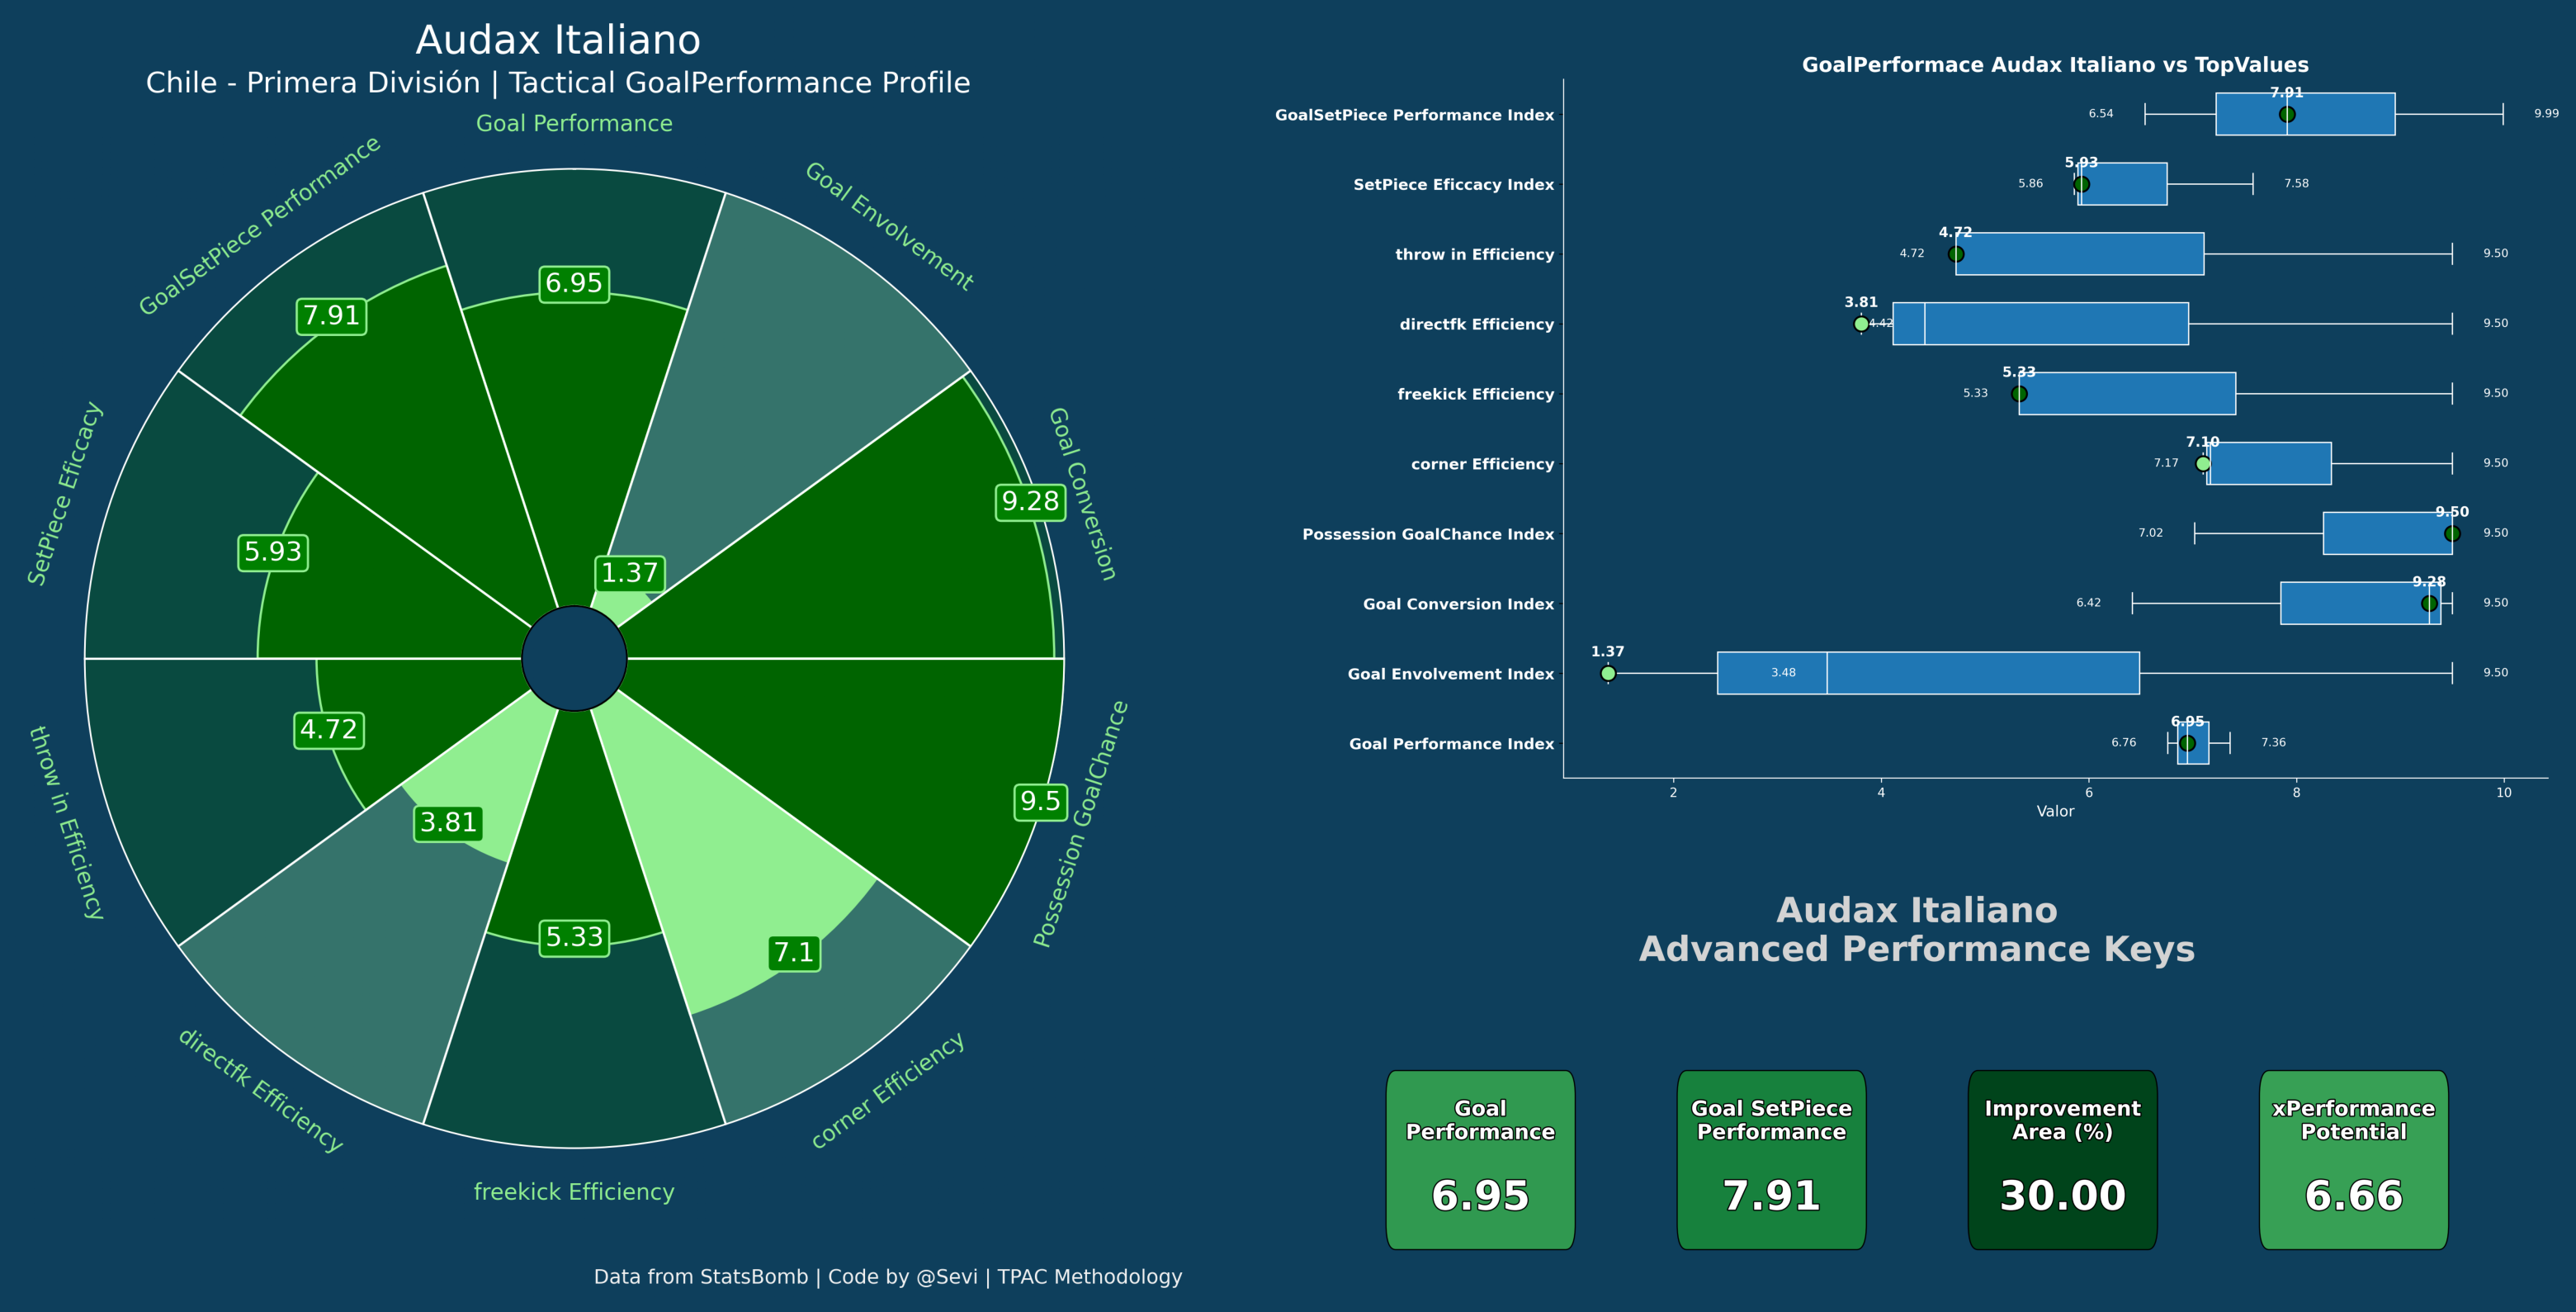

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Color de fondo para los espacios vacíos
bg_color = "#0E3F5C"

# Rutas de las imágenes
img1_path = "AUDAX/Audax Italiano_GoalPerformance_Profile.png"
img2_path = "AUDAX/GoalPerformanceAudax Italiano vs TopValues.png"
img3_path = "AUDAX/GoalPerformance Audax Italiano - Adavanced Indexes.png"

# Crear figura y layout de 3x2
fig = plt.figure(figsize=(32, 16), facecolor=bg_color)  # Fondo de la figura
gs = gridspec.GridSpec(3, 2, figure=fig)

# Imagen 1 (ocupa todas las filas en la 1ª columna)
ax1 = fig.add_subplot(gs[:, 0])
ax1.set_facecolor(bg_color)
img1 = mpimg.imread(img1_path)
ax1.imshow(img1)
ax1.axis('off')

# Imagen 2 (ocupa las dos primeras filas de la 2ª columna)
ax2 = fig.add_subplot(gs[0:2, 1])
ax2.set_facecolor(bg_color)
img2 = mpimg.imread(img2_path)
ax2.imshow(img2)
ax2.axis('off')

# Imagen 3 (ocupa la última fila, columna 2)
ax3 = fig.add_subplot(gs[2, 1])
ax3.set_facecolor(bg_color)
img3 = mpimg.imread(img3_path)
ax3.imshow(img3)
ax3.axis('off')

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()


## Unificamos los 4 codigos para generar un plot de "GoalPerformance"

Dropdown(description='Selecciona equipo:', index=1, layout=Layout(width='50%'), options=('Audax Italiano', 'Co…

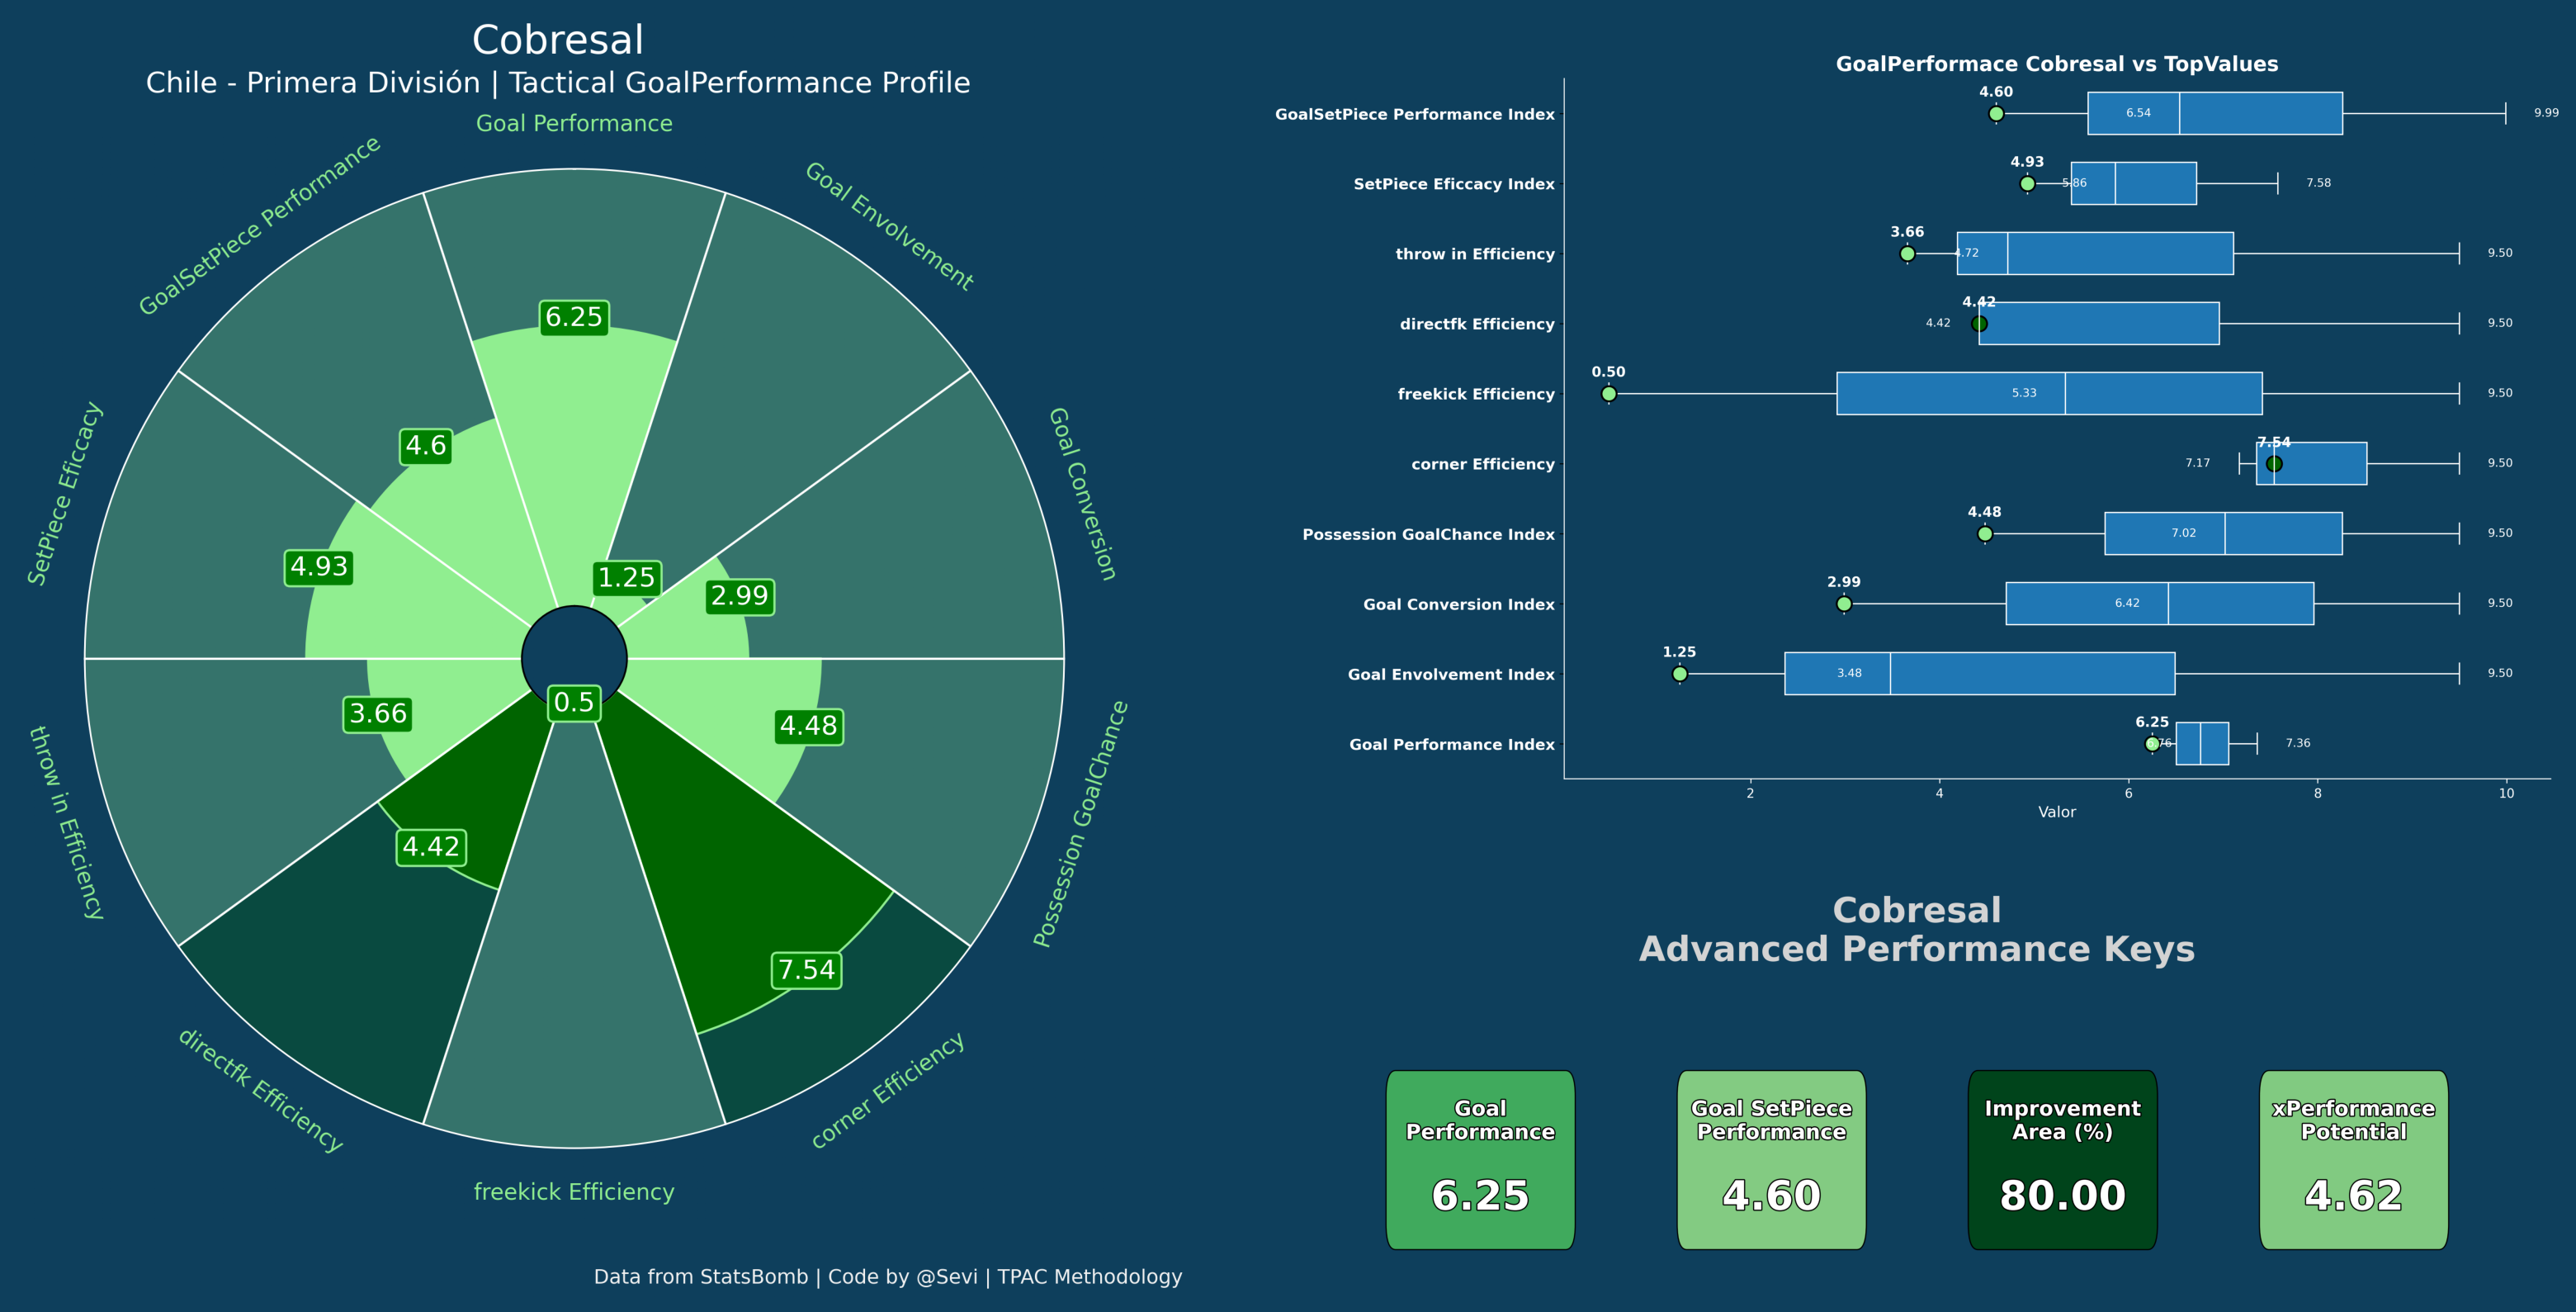

In [26]:
# -------------------------------------------
# 📌 MÓDULOS Y LIBRERIAS
# -------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from PIL import Image
from mplsoccer import PyPizza
from mplsoccer.utils import add_image
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np


# -------------------------------------------
# 📌 CARGA DE DATOS
# -------------------------------------------
df = pd.read_csv('AUDAX/df_GoalKPIs_TopValues.csv')
equipos = df[~df["team_name"].str.contains("TopValues")]["team_name"].unique()

# -------------------------------------------
# 📌 DESPLEGABLE DINÁMICO
# -------------------------------------------
dropdown = widgets.Dropdown(
    options=sorted(equipos),
    description='Selecciona equipo:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)
display(dropdown)

# -------------------------------------------
# 📌 FUNCIÓN PRINCIPAL PARA GRAFICAR TODO
# -------------------------------------------
def generar_todos_los_graficos(team_name):
    # Carpetas
    output_dir = "AUDAX/"
    badge_path = f"Chile Primeradivision/{team_name}.png"
    ligue_path = f"Chile Primeradivision/Liga de Primera Itaú.png"

    # --------------------- 1. RADAR ---------------------
    display_cols = [
        "team_name",
        "Goal Performance Index", "Goal Envolvement Index",
        "Goal Conversion Index", "Possession GoalChance Index",
        "corner Efficiency", "freekick Efficiency",
        "directfk Efficiency", "throw in Efficiency",
        "SetPiece Eficcacy Index", "GoalSetPiece Performance Index"
    ]
    team_data = df[df["team_name"] == team_name][display_cols].iloc[0]
    values = team_data[1:].astype(float).values
    top_min = df[df["team_name"] == "TopValues (min)"][display_cols[1:]].astype(float).values[0]
    params = [c.replace(" Index", "").replace(" Efficacy", "") for c in display_cols[1:]]
    min_values = [0.5] * len(params)
    max_values = [9.5] * len(params)
    slice_colors = ["lightgreen" if values[i] < top_min[i] else "darkgreen" for i in range(len(values))]

    bg_color = '#0E3F5C'
    baker = PyPizza(
        params=params,
        min_range=min_values,
        max_range=max_values,
        background_color=bg_color,
        straight_line_color="white",
        last_circle_color="white",
        last_circle_lw=1.5,
        straight_line_lw=1,
        other_circle_lw=0,
        other_circle_color="white",
        inner_circle_size=12,
    )

    fig1, ax = baker.make_pizza(
        values,
        figsize=(8, 8),
        color_blank_space="same",
        blank_alpha=0.3,
        param_location=110,
        slice_colors=slice_colors,
        kwargs_slices=dict(facecolor="lightgreen", edgecolor="lightgreen", zorder=1, linewidth=1),
        kwargs_params=dict(color="lightgreen", fontsize=10, zorder=5, va="center"),
        kwargs_values=dict(color="white", fontsize=12, zorder=3,
                           bbox=dict(edgecolor="lightgreen", facecolor="green",
                                     boxstyle="round,pad=0.2", lw=1))
    )
    fig1.text(0.5, 0.97, team_name, size=18, ha="center", color="white")
    fig1.text(0.5, 0.94,
              "Chile - Primera División | Tactical GoalPerformance Profile",
              size=13, ha="center", color="white")
    fig1.text(0.99, 0.005,
              "Data from StatsBomb | Code by @Sevi | TPAC Methodology",
              size=9, color="#F2F2F2", ha='right')
    if os.path.exists(badge_path):
        badge = Image.open(badge_path)
        add_image(badge, fig1, left=0.425, bottom=0.41, width=0.17, height=0.17)
    if os.path.exists(ligue_path):
        ligue = Image.open(ligue_path)
        add_image(ligue, fig1, left=0.02, bottom=0.01, width=0.15, height=0.15)
    radar_path = f"{output_dir}{team_name}_GoalPerformance_Profile.png"
    fig1.savefig(radar_path, dpi=300, bbox_inches='tight', facecolor=fig1.get_facecolor())
    plt.close(fig1)

    # --------------------- 2. BOXPLOT ---------------------
    kpi_names = display_cols[1:]
    top_min_vals = df.loc[df["team_name"] == "TopValues (min)", kpi_names].iloc[0].astype(float)
    top_max_vals = df.loc[df["team_name"] == "TopValues (max)", kpi_names].iloc[0].astype(float)
    team_vals = df.loc[df["team_name"] == team_name, kpi_names].iloc[0].astype(float)
    data = [[top_min_vals[kpi], team_vals[kpi], top_max_vals[kpi]] for kpi in kpi_names]

    def get_color(val, mn, mx):
        return 'lightgreen' if val < mn else 'darkgreen'

    fig2, ax = plt.subplots(figsize=(14, 10))
    fig2.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)
    ax.boxplot(data, vert=False, patch_artist=True, widths=0.6,
               boxprops=dict(color='white'), medianprops=dict(color='white'),
               whiskerprops=dict(color='white'), capprops=dict(color='white'),
               flierprops=dict(marker='o', color='white', alpha=0.5))
    for i, kpi in enumerate(kpi_names):
        val = team_vals[kpi]
        color = get_color(val, top_min_vals[kpi], top_max_vals[kpi])
        ax.plot(val, i+1, 'o', markersize=12, color=color, markeredgecolor='black', markeredgewidth=1.5)
        ax.text(val, i+1 + 0.2, f'{val:.2f}', ha='center', va='bottom', fontsize=11, color='white', fontweight='bold')
        ax.text(top_min_vals[kpi] - 0.3, i+1, f'{top_min_vals[kpi]:.2f}', ha='right', va='center', fontsize=9, color='white')
        ax.text(top_max_vals[kpi] + 0.3, i+1, f'{top_max_vals[kpi]:.2f}', ha='left', va='center', fontsize=9, color='white')
    ax.set_yticks(range(1, len(kpi_names)+1))
    ax.set_yticklabels(kpi_names, color='white', fontsize=12, fontweight='bold')
    ax.set_xlabel("Valor", color='white', fontsize=12)
    ax.tick_params(axis='x', colors='white')
    for side in ['top', 'right']:
        ax.spines[side].set_visible(False)
    for side in ['bottom', 'left']:
        ax.spines[side].set_color('white')
    ax.set_title(f'GoalPerformace {team_name} vs TopValues', color='white', fontsize=16, fontweight='bold')
    if os.path.exists(badge_path):
        badge = Image.open(badge_path)
        add_image(badge, fig2, left=0.25, bottom=0.2, width=0.65, height=0.65, alpha=0.2)
    boxplot_path = f"{output_dir}GoalPerformance{team_name} vs TopValues.png"
    fig2.savefig(boxplot_path, dpi=300, bbox_inches='tight', facecolor=fig2.get_facecolor())
    plt.close(fig2)

    # --------------------- 3. BOXES PERFORMANCE ---------------------
    top_min = df.loc[df["team_name"] == "TopValues (min)", kpi_names].iloc[0].astype(float)
    top_max = df.loc[df["team_name"] == "TopValues (max)", kpi_names].iloc[0].astype(float)
    row = df.loc[df["team_name"] == team_name, kpi_names].iloc[0].astype(float)

    goal_perf = row["Goal Performance Index"]
    setpiece_perf = row["GoalSetPiece Performance Index"]
    below = (row < top_min).sum()
    improvement_pct = (below / len(kpi_names)) * 100
    x_perf = (row / top_max).mean() * (9.5 - 0.5) + 0.5

    metrics = [
        ("Goal\nPerformance", goal_perf),
        ("Goal SetPiece\nPerformance", setpiece_perf),
        ("Improvement\nArea (%)", improvement_pct),
        ("xPerformance\nPotential", x_perf)
    ]

    cmap = cm.get_cmap('Greens')
    norm = mcolors.Normalize(vmin=0, vmax=10)
    outline_effect = [path_effects.withStroke(linewidth=2, foreground='black')]
    spacing = 6
    box_width, box_height = 3.5, 1

    fig3, ax = plt.subplots(figsize=(20, 5), facecolor=bg_color)
    ax.set_facecolor(bg_color)
    for i, (label, val) in enumerate(metrics):
        x0 = i * spacing
        color = cmap(norm(val))
        box = patches.FancyBboxPatch((x0, 0.5), width=box_width, height=box_height,
                                     boxstyle="round,pad=0.2", edgecolor='black', facecolor=color)
        ax.add_patch(box)
        ax.text(x0 + box_width/2, 1.3, label, ha='center', va='center',
                fontsize=18, fontweight='bold', color='white', path_effects=outline_effect)
        ax.text(x0 + box_width/2, 0.7, f"{val:.2f}", ha='center', va='center',
                fontsize=35, fontweight='bold', color='white', path_effects=outline_effect)
    ax.set_xlim(-2.5, spacing * len(metrics))
    ax.set_ylim(0, 2.5)
    ax.axis('off')
    ax.set_title(f"{team_name}\nAdvanced Performance Keys", color='lightgray', fontsize=30, fontweight='bold', pad=3)
    if os.path.exists(badge_path):
        badge = Image.open(badge_path)
        add_image(badge, fig3, left=0.12, bottom=0.75, width=0.25, height=0.25, alpha=0.8)
    if os.path.exists(ligue_path):
        ligue = Image.open(ligue_path)
        add_image(ligue, fig3, left=0.65, bottom=0.73, width=0.25, height=0.25)
    box_path = f"{output_dir}GoalPerformance {team_name} - Adavanced Indexes.png"
    fig3.savefig(box_path, dpi=300, bbox_inches='tight', facecolor=fig3.get_facecolor())
    plt.close(fig3)

    # --------------------- 4. UNIFICAR IMÁGENES ---------------------
    fig = plt.figure(figsize=(32, 16), facecolor=bg_color)
    gs = gridspec.GridSpec(3, 2, figure=fig)

    ax1 = fig.add_subplot(gs[:, 0])
    ax1.imshow(mpimg.imread(radar_path))
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0:2, 1])
    ax2.imshow(mpimg.imread(boxplot_path))
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[2, 1])
    ax3.imshow(mpimg.imread(box_path))
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------------------------
# 📌 VINCULAR FUNCIÓN A CAMBIO DE SELECCIÓN
# -------------------------------------------
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output(wait=True)
        display(dropdown)
        generar_todos_los_graficos(change['new'])

dropdown.observe(on_change)


# Visualizaciones

### 1º**Preparamos "df_GoalPerformance"**
### 2º**Visualizaciones (Descriptivas, Evolutivas, Comparativas)**
 


In [27]:
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# --- Cargar datos ---
@st.cache_data
def load_data():
    return pd.read_csv("AUDAX/df_final.csv")  # O usar ruta absoluta si es necesario

df = load_data()

# --- Título ---
st.title("Evolución de KPIs por equipo (por partido)")

# --- Filtrar los datos por partido (excluir promedios) ---
match_df = df[df["match_id"] != "AVG"]

# --- Lista de equipos disponibles ---
team_list = match_df["team_name"].unique()
team_selected = st.selectbox("Selecciona un equipo para analizar:", sorted(team_list))

# --- KPIs disponibles ---
kpi_options = [
    "Goal Envolvement Index (norm)",
    "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)",
    "Goal Performance Index"
]
kpi_selected = st.selectbox("Selecciona un KPI:", kpi_options)

# --- Filtrar datos del equipo seleccionado ---
team_df = match_df[match_df["team_name"] == team_selected].sort_values("match_id")

# --- Calcular líneas promedio ---
team_avg = team_df[kpi_selected].mean()
all_teams_avg = match_df[kpi_selected].mean()

# --- Crear gráfico ---
fig = go.Figure()

# Evolución del equipo
fig.add_trace(go.Scatter(
    x=team_df["match_id"],
    y=team_df[kpi_selected],
    mode='lines+markers',
    name=team_selected,
    line=dict(color="blue")
))

# Línea promedio del equipo
fig.add_trace(go.Scatter(
    x=team_df["match_id"],
    y=[team_avg] * len(team_df),
    mode='lines',
    name=f"Promedio {team_selected}",
    line=dict(color="blue", dash="dash")
))

# Línea promedio general
fig.add_trace(go.Scatter(
    x=team_df["match_id"],
    y=[all_teams_avg] * len(team_df),
    mode='lines',
    name="Promedio Todos los Equipos",
    line=dict(color="gray", dash="dot")
))

# Configuración del gráfico
fig.update_layout(
    title=f"Evolución de {kpi_selected} - {team_selected}",
    xaxis_title="Partido (match_id)",
    yaxis_title=kpi_selected,
    legend_title="Leyenda",
    template="plotly_white"
)

# Mostrar gráfico
st.plotly_chart(fig)


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import re

# --- Cargar datos ---
df = pd.read_csv("AUDAX/df_final.csv")

# --- Filtrar partidos reales (no promedios AVG) ---
match_df = df[df["match_id"] != "AVG"].copy()
match_df["match_id"] = match_df["match_id"].astype(str)

# --- Extraer nombres y goles desde match_score ---
def parse_score(row):
    try:
        score = row["match_score"]
        match = re.match(r"(.*)\((\d+)\) - (.*)\((\d+)\)", score)
        if not match:
            return pd.Series([None, None, None])
        team1, goals1, team2, goals2 = match.groups()
        if row["team_name"] == team1.strip():
            return pd.Series([team2.strip(), int(goals1), int(goals2)])
        else:
            return pd.Series([team1.strip(), int(goals2), int(goals1)])
    except:
        return pd.Series([None, None, None])

match_df[["opponent_name", "team_goals", "opponent_goals"]] = match_df.apply(parse_score, axis=1)

# --- Crear etiqueta personalizada para eje X ---
match_df["x_label"] = (
    "J" + match_df["match_week"].astype(str) + ": " +
    match_df["team_name"] + " (" + match_df["team_goals"].astype(str) + ") - " +
    match_df["opponent_name"] + " (" + match_df["opponent_goals"].astype(str) + ")"
)

# --- Opciones únicas ---
teams = sorted(match_df["team_name"].unique())
kpi_options = [
    "Goal Envolvement Index (norm)",
    "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)",
    "Goal Performance Index"
]

# --- Widgets ---
team_select = widgets.SelectMultiple(
    options=teams,
    value=[teams[0]],
    description="Equipos",
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

kpi_dropdown = widgets.Dropdown(
    options=kpi_options,
    value=kpi_options[0],
    description="KPI:"
)

# Botones de exportación
export_png = widgets.Button(description="📷 Exportar PNG", button_style='primary')
export_svg = widgets.Button(description="🖼️ Exportar SVG", button_style='primary')
export_output = widgets.Output()

# --- Crear figura ---
fig = go.FigureWidget()

# --- Función para actualizar gráfico ---
def update_plot(change=None):
    selected_teams = team_select.value[:7]  # máximo 7
    kpi_selected = kpi_dropdown.value
    fig.data = []

    for i, team in enumerate(selected_teams):
        team_df = match_df[match_df["team_name"] == team].sort_values("match_week")
        team_avg = team_df[kpi_selected].mean()

        # Línea de evolución en lightgreen
        fig.add_trace(go.Scatter(
            x=team_df["x_label"],
            y=team_df[kpi_selected],
            mode="lines+markers+text",
            name=team,
            line=dict(color="lightgreen", width=2),
            marker=dict(size=10, color="lightgreen"),
            text=[f"{v:.2f}" for v in team_df[kpi_selected]],
            textposition="top center",
            textfont=dict(color="lightgreen", size=11)
        ))

        # Línea promedio del equipo
        fig.add_trace(go.Scatter(
            x=team_df["x_label"],
            y=[team_avg] * len(team_df),
            mode="lines",
            name=f"Prom. {team}",
            line=dict(color="yellow", dash="dash", width=2)
        ))

    # Línea promedio de todos los equipos
    if selected_teams:
        ref_team_df = match_df[match_df["team_name"] == selected_teams[0]].sort_values("match_week")
        all_avg = match_df[kpi_selected].mean()

        fig.add_trace(go.Scatter(
            x=ref_team_df["x_label"],
            y=[all_avg] * len(ref_team_df),
            mode="lines",
            name="Prom. Todos los equipos",
            line=dict(color="orange", dash="dot", width=3)
        ))

    # Actualizar layout con colores y fondo
    fig.update_layout(
        template="plotly_white",
        plot_bgcolor="#0E3F5C",    # Fondo del área del gráfico
        paper_bgcolor="#0E3F5C",   # Fondo total del lienzo
        font=dict(color="white"), # Texto blanco
        xaxis_title="Partido (Jornada y Resultado)",
        yaxis_title=kpi_selected,
        hovermode="x unified",
        height=600,
        title=dict(text=f"{kpi_selected}", font=dict(color="white")),
        legend=dict(
            orientation="h", 
            yanchor="bottom", y=1.02, 
            xanchor="right", x=1,
            font=dict(color="white")
        ),
        xaxis=dict(
            tickfont=dict(size=9, color="white"),
            tickangle=45,
            showgrid=True,
            gridcolor="rgba(255, 255, 255, 0.1)"
        ),
        yaxis=dict(
            tickfont=dict(color="white"),
            showgrid=True,
            gridcolor="rgba(255, 255, 255, 0.1)"
        )
    )

# --- Funciones exportar ---
def export_as_png(b):
    with export_output:
        fig.write_image("grafico_exportado.png")
        print("✅ Exportado como PNG: grafico_exportado.png")

def export_as_svg(b):
    with export_output:
        fig.write_image("grafico_exportado.svg")
        print("✅ Exportado como SVG: grafico_exportado.svg")

export_png.on_click(export_as_png)
export_svg.on_click(export_as_svg)

# --- Conectar eventos ---
team_select.observe(update_plot, names="value")
kpi_dropdown.observe(update_plot, names="value")

# --- Mostrar interfaz ---
ui = widgets.VBox([
    team_select,
    kpi_dropdown,
    widgets.HBox([export_png, export_svg]),
    export_output
])
display(ui, fig)

# --- Inicializar ---
update_plot()


FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import re
import os
import base64
from io import BytesIO
from PIL import Image

# --- Cargar datos ---
df = pd.read_csv("AUDAX/df_final.csv")

# --- Filtrar partidos reales (no promedios AVG) ---
match_df = df[df["match_id"] != "AVG"].copy()
match_df["match_id"] = match_df["match_id"].astype(str)

# --- Extraer nombres y goles desde match_score ---
def parse_score(row):
    try:
        score = row["match_score"]
        match = re.match(r"(.*)\((\d+)\) - (.*)\((\d+)\)", score)
        if not match:
            return pd.Series([None, None, None])
        team1, goals1, team2, goals2 = match.groups()
        if row["team_name"] == team1.strip():
            return pd.Series([team2.strip(), int(goals1), int(goals2)])
        else:
            return pd.Series([team1.strip(), int(goals2), int(goals1)])
    except:
        return pd.Series([None, None, None])

match_df[["opponent_name", "team_goals", "opponent_goals"]] = match_df.apply(parse_score, axis=1)

# --- Crear etiqueta personalizada para eje X ---
match_df["x_label"] = (
    "J" + match_df["match_week"].astype(str) + ": " +
    match_df["team_name"] + " (" + match_df["team_goals"].astype(str) + ") - " +
    match_df["opponent_name"] + " (" + match_df["opponent_goals"].astype(str) + ")"
)

# --- Opciones únicas ---
teams = sorted(match_df["team_name"].unique())
kpi_options = [
    "Goal Envolvement Index (norm)",
    "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)",
    "Goal Performance Index"
]

# --- Widgets ---
team_select = widgets.SelectMultiple(
    options=teams,
    value=[teams[0]],
    description="Equipos",
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

kpi_dropdown = widgets.Dropdown(
    options=kpi_options,
    value=kpi_options[0],
    description="KPI:"
)

# Botones de exportación
export_png = widgets.Button(description="📷 Exportar PNG", button_style='primary')
export_svg = widgets.Button(description="🖼️ Exportar SVG", button_style='primary')
export_output = widgets.Output()

# --- Ruta donde están los escudos ---
shields_folder = "Chile Primeradivision"  # <-- Cambia esta ruta a tu carpeta con PNGs

# --- Función para convertir imagen PIL a base64 para Plotly ---
def pil_to_base64(img):
    buffer = BytesIO()
    img.save(buffer, format="PNG")
    encoded = base64.b64encode(buffer.getvalue()).decode()
    return f"data:image/png;base64,{encoded}"

# --- Función para añadir escudo a la figura ---
def add_team_shield(fig, team_name, x=0.7, y=1, size=0.15):
    shield_path = os.path.join(shields_folder, f"{team_name}.png")
    if os.path.exists(shield_path):
        img = Image.open(shield_path)
        img_b64 = pil_to_base64(img)
        fig.add_layout_image(
            dict(
                source=img_b64,
                xref="paper", yref="paper",
                x=x, y=y,
                sizex=size, sizey=size,
                xanchor="left",
                yanchor="top",
                layer="above",
                sizing="contain"
            )
        )

# --- Crear figura ---
fig = go.FigureWidget()

# --- Función para actualizar gráfico ---
def update_plot(change=None):
    selected_teams = team_select.value[:7]  # máximo 7
    kpi_selected = kpi_dropdown.value
    fig.data = []
    fig.layout.images = []  # Limpiar imágenes anteriores

    for i, team in enumerate(selected_teams):
        team_df = match_df[match_df["team_name"] == team].sort_values("match_week")
        team_avg = team_df[kpi_selected].mean()

        # Línea principal
        fig.add_trace(go.Scatter(
            x=team_df["x_label"],
            y=team_df[kpi_selected],
            mode="lines+markers+text",
            name=team,
            line=dict(color="lightgreen", width=2),
            marker=dict(size=10, color="lightgreen"),
            text=[f"{v:.2f}" for v in team_df[kpi_selected]],
            textposition="top center",
            textfont=dict(color="lightgreen", size=11)
        ))

        # Línea promedio del equipo
        fig.add_trace(go.Scatter(
            x=team_df["x_label"],
            y=[team_avg] * len(team_df),
            mode="lines",
            name=f"Prom. {team}",
            line=dict(color="mediumseagreen", dash="dash", width=2)
        ))

        # Añadir escudo junto al gráfico, desplazados verticalmente para que no se solapen
        add_team_shield(fig, team, x=1, y=1.18 - i * 0.18, size=0.20)

    # Promedio de todos los equipos
    if selected_teams:
        ref_team_df = match_df[match_df["team_name"] == selected_teams[0]].sort_values("match_week")
        all_avg = match_df[kpi_selected].mean()

        fig.add_trace(go.Scatter(
            x=ref_team_df["x_label"],
            y=[all_avg] * len(ref_team_df),
            mode="lines",
            name="Prom. Todos los equipos",
            line=dict(color="orange", dash="dot", width=3)
        ))

    # Actualizar layout
    fig.update_layout(
        template="plotly_white",
        plot_bgcolor="#0E3F5C",    # Fondo del área del gráfico
        paper_bgcolor="#0E3F5C",   # Fondo total del lienzo
        font=dict(color="white"), # Texto blanco
        xaxis_title="Partido (Jornada y Resultado)",
        yaxis_title=kpi_selected,
        hovermode="x unified",
        height=600,
        title=dict(text=f"{kpi_selected}", font=dict(color="white")),
        legend=dict(
            orientation="h", 
            yanchor="bottom", y=1.02, 
            xanchor="right", x=1,
            font=dict(color="white")
        ),
        xaxis=dict(
            tickfont=dict(size=9, color="white"),
            tickangle=45,
            showgrid=True,
            gridcolor="rgba(255, 255, 255, 0.1)"
        ),
        yaxis=dict(
            tickfont=dict(color="white"),
            showgrid=True,
            gridcolor="rgba(255, 255, 255, 0.1)"
        )
    )


# --- Funciones exportar ---
def export_as_png(b):
    with export_output:
        fig.write_image("grafico_exportado.png")
        print("✅ Exportado como PNG: grafico_exportado.png")

def export_as_svg(b):
    with export_output:
        fig.write_image("grafico_exportado.svg")
        print("✅ Exportado como SVG: grafico_exportado.svg")

export_png.on_click(export_as_png)
export_svg.on_click(export_as_svg)

# --- Conectar eventos ---
team_select.observe(update_plot, names="value")
kpi_dropdown.observe(update_plot, names="value")

# --- Mostrar interfaz ---
ui = widgets.VBox([
    team_select,
    kpi_dropdown,
    widgets.HBox([export_png, export_svg]),
    export_output
])
display(ui, fig)



# --- Inicializar ---
update_plot()


FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import os

# --- Cargar datos ---
df = pd.read_csv("AUDAX/df_final.csv")

# --- Filtrar partidos reales ---
match_df = df[df["match_id"] != "AVG"].copy()
match_df["match_id"] = match_df["match_id"].astype(str)

# --- Crear columna combinada para eje X: Jornada + Resultado ---
match_df["x_label"] = match_df.apply(
    lambda row: f"J{row['match_week']}: {row['match_score']}", axis=1
)

# --- Opciones únicas ---
teams = sorted(match_df["team_name"].unique())
kpi_list = [
    "Goal Envolvement Index (norm)",
    "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)",
    "Goal Performance Index"
]

# --- Widgets ---
team_select = widgets.SelectMultiple(
    options=teams,
    value=[teams[0]],
    description="Equipos",
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

# Botones de exportación
export_png = widgets.Button(description="📷 Exportar PNG", button_style='primary')
export_svg = widgets.Button(description="🖼️ Exportar SVG", button_style='primary')
export_output = widgets.Output()


# --- Crear FigureWidgets por KPI ---
figs = {kpi: go.FigureWidget() for kpi in kpi_list}

for kpi, fig in figs.items():
    # Quitar "(norm)" del título
    kpi_title = kpi.replace(" (norm)", "")

    fig.update_layout(
        template="plotly_white",
        xaxis_title="Partido (Jornada y Resultado)",
        yaxis_title=kpi_title,
        title=dict(text=kpi_title, font=dict(color="white")),
        hovermode="x unified",
        height=600,
        plot_bgcolor="#0E3F5C",
        paper_bgcolor="#0E3F5C",
        font=dict(color="white"),
        legend=dict(
            orientation="h", 
            yanchor="bottom", y=1.02, 
            xanchor="right", x=1,
            font=dict(color="white")
        ),
        xaxis=dict(
            tickfont=dict(size=9, color="white"),
            tickangle=45,
            showgrid=True,
            gridcolor="rgba(255, 255, 255, 0.1)"
        ),
        yaxis=dict(
            tickfont=dict(color="white"),
            showgrid=True,
            gridcolor="rgba(255, 255, 255, 0.1)"
        )
    )

# --- Función para actualizar todos los gráficos ---
def update_all_plots(change=None):
    selected_teams = team_select.value[:7]
    
    for kpi, fig in figs.items():
        fig.data = []
        kpi_title = kpi.replace(" (norm)", "")

        for i, team in enumerate(selected_teams):
            team_df = match_df[match_df["team_name"] == team].sort_values("match_week")
            team_avg = team_df[kpi].mean()

            # Línea principal
            fig.add_trace(go.Scatter(
                x=team_df["x_label"],
                y=team_df[kpi],
                mode="lines+markers+text",
                name=team,
                line=dict(color="lightgreen", width=2),
                marker=dict(size=10, color="lightgreen"),
                text=[f"{v:.2f}" for v in team_df[kpi]],
                textposition="top center",
                textfont=dict(size=11, color="lightgreen")
            ))

            # Promedio del equipo
            fig.add_trace(go.Scatter(
                x=team_df["x_label"],
                y=[team_avg] * len(team_df),
                mode="lines",
                name=f"Prom. {team}",
                line=dict(color="mediumseagreen", dash="dash", width=2)
            ))

        # Promedio de todos los equipos
        if selected_teams:
            ref_df = match_df[match_df["team_name"] == selected_teams[0]].sort_values("match_week")
            all_avg = match_df[kpi].mean()

            fig.add_trace(go.Scatter(
                x=ref_df["x_label"],
                y=[all_avg] * len(ref_df),
                mode="lines",
                name="Prom. Todos los equipos",
                line=dict(color="orange", dash="dot", width=3)
            ))


# --- Carpeta donde guardar las imágenes ---
output_folder = "AUDAX"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# --- Funciones de exportación actualizadas ---
def export_as_png(b):
    with export_output:
        export_output.clear_output()
        for kpi, fig in figs.items():
            filename = f"{kpi.replace(' ', '_')}.png"
            filepath = os.path.join(output_folder, filename)
            fig.write_image(filepath)
        print(f"✅ Exportados como PNG en carpeta: {output_folder}")

def export_as_svg(b):
    with export_output:
        export_output.clear_output()
        for kpi, fig in figs.items():
            filename = f"{kpi.replace(' ', '_')}.svg"
            filepath = os.path.join(output_folder, filename)
            fig.write_image(filepath)
        print(f"✅ Exportados como SVG en carpeta: {output_folder}")

# --- Conectar eventos ---
team_select.observe(update_all_plots, names="value")

# --- Mostrar interfaz ---
ui = widgets.VBox([
    team_select,
    widgets.HBox([export_png, export_svg]),
    export_output
])
display(ui, *figs.values())


# --- Inicializar ---
update_all_plots()


FigureWidget({
    'data': [],
    'layout': {'font': {'color': 'white'},
               'height': 600,
               'hovermode': 'x unified',
               'legend': {'font': {'color': 'white'},
                          'orientation': 'h',
                          'x': 1,
                          'xanchor': 'right',
                          'y': 1.02,
                          'yanchor': 'bottom'},
               'paper_bgcolor': '#0E3F5C',
               'plot_bgcolor': '#0E3F5C',
               'template': '...',
               'title': {'font': {'color': 'white'}, 'text': 'Goal Envolvement Index'},
               'xaxis': {'gridcolor': 'rgba(255, 255, 255, 0.1)',
                         'showgrid': True,
                         'tickangle': 45,
                         'tickfont': {'color': 'white', 'size': 9},
                         'title': {'text': 'Partido (Jornada y Resultado)'}},
               'yaxis': {'gridcolor': 'rgba(255, 255, 255, 0.1)',
                    

FigureWidget({
    'data': [],
    'layout': {'font': {'color': 'white'},
               'height': 600,
               'hovermode': 'x unified',
               'legend': {'font': {'color': 'white'},
                          'orientation': 'h',
                          'x': 1,
                          'xanchor': 'right',
                          'y': 1.02,
                          'yanchor': 'bottom'},
               'paper_bgcolor': '#0E3F5C',
               'plot_bgcolor': '#0E3F5C',
               'template': '...',
               'title': {'font': {'color': 'white'}, 'text': 'Goal Conversion Index'},
               'xaxis': {'gridcolor': 'rgba(255, 255, 255, 0.1)',
                         'showgrid': True,
                         'tickangle': 45,
                         'tickfont': {'color': 'white', 'size': 9},
                         'title': {'text': 'Partido (Jornada y Resultado)'}},
               'yaxis': {'gridcolor': 'rgba(255, 255, 255, 0.1)',
                     

FigureWidget({
    'data': [],
    'layout': {'font': {'color': 'white'},
               'height': 600,
               'hovermode': 'x unified',
               'legend': {'font': {'color': 'white'},
                          'orientation': 'h',
                          'x': 1,
                          'xanchor': 'right',
                          'y': 1.02,
                          'yanchor': 'bottom'},
               'paper_bgcolor': '#0E3F5C',
               'plot_bgcolor': '#0E3F5C',
               'template': '...',
               'title': {'font': {'color': 'white'}, 'text': 'Possession GoalChance Index'},
               'xaxis': {'gridcolor': 'rgba(255, 255, 255, 0.1)',
                         'showgrid': True,
                         'tickangle': 45,
                         'tickfont': {'color': 'white', 'size': 9},
                         'title': {'text': 'Partido (Jornada y Resultado)'}},
               'yaxis': {'gridcolor': 'rgba(255, 255, 255, 0.1)',
               

FigureWidget({
    'data': [],
    'layout': {'font': {'color': 'white'},
               'height': 600,
               'hovermode': 'x unified',
               'legend': {'font': {'color': 'white'},
                          'orientation': 'h',
                          'x': 1,
                          'xanchor': 'right',
                          'y': 1.02,
                          'yanchor': 'bottom'},
               'paper_bgcolor': '#0E3F5C',
               'plot_bgcolor': '#0E3F5C',
               'template': '...',
               'title': {'font': {'color': 'white'}, 'text': 'Goal Performance Index'},
               'xaxis': {'gridcolor': 'rgba(255, 255, 255, 0.1)',
                         'showgrid': True,
                         'tickangle': 45,
                         'tickfont': {'color': 'white', 'size': 9},
                         'title': {'text': 'Partido (Jornada y Resultado)'}},
               'yaxis': {'gridcolor': 'rgba(255, 255, 255, 0.1)',
                    

In [ ]:
pip install ipywidgets matplotlib pandas



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


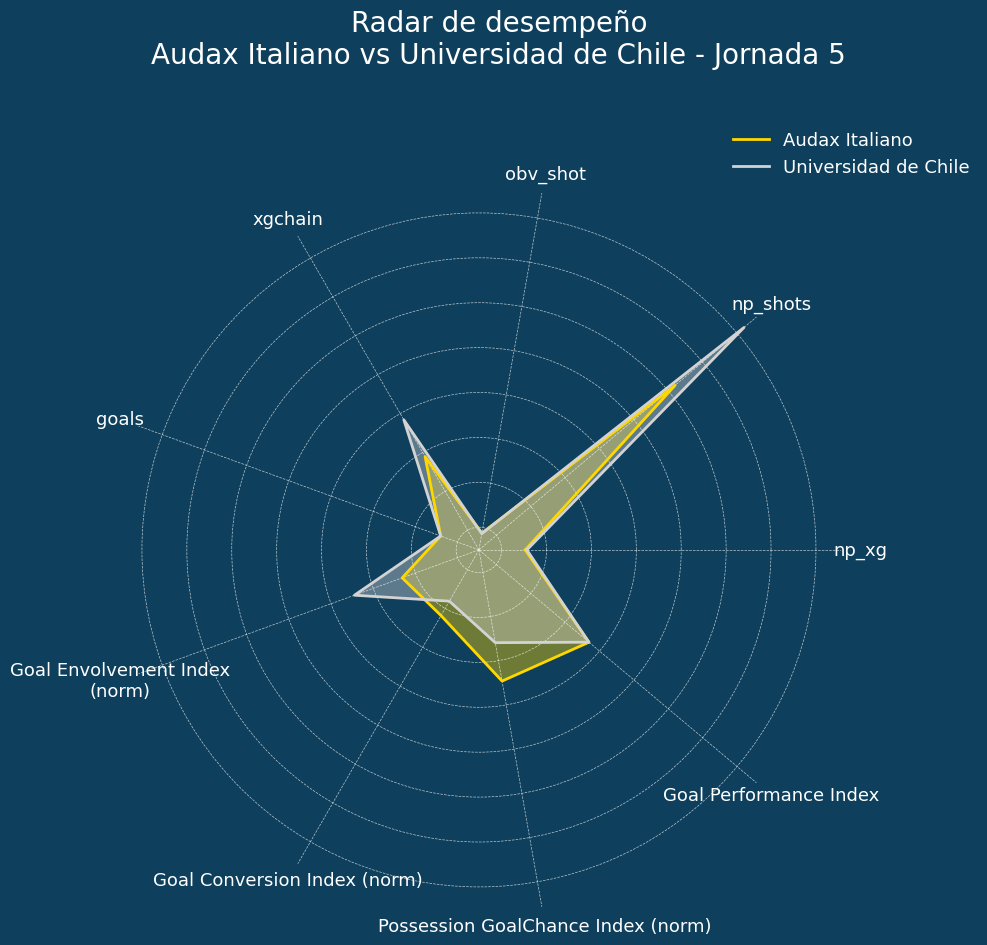

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from matplotlib.font_manager import FontProperties

# --- Cargar datos ---
df = pd.read_csv("AUDAX/df_final.csv")

# --- Métricas a mostrar en radar ---
metrics = [
    "np_xg", "np_shots", "obv_shot", "xgchain", "goals",
    "Goal Envolvement Index (norm)", "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)", "Goal Performance Index"
]

df[metrics] = df[metrics].apply(pd.to_numeric, errors="coerce")

# --- Selección del equipo y jornada ---
equipo = "Audax Italiano"
jornada = 5  # Cambia a la jornada deseada

# --- Filtrar datos del partido ---
match_data = df[(df["team_name"].isin([equipo])) & (df["match_week"] == jornada)]

if match_data.empty:
    raise ValueError("❌ No se encontró el equipo en esa jornada.")

match_id = match_data.iloc[0]["match_id"]
rival_data = df[(df["match_id"] == match_id) & (df["team_name"] != equipo)]

if rival_data.empty:
    raise ValueError("❌ No se encontró rival en esa jornada.")

team_df = match_data.iloc[0]
rival_df = rival_data.iloc[0]

# --- Preparar datos ---
team_values = [team_df[m] for m in metrics]
rival_values = [rival_df[m] for m in metrics]

# --- Radar chart ---
def radar_equipo_vs_rival(team_name, rival_name, team_vals, rival_vals):
    categories = metrics
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    team_vals += team_vals[:1]
    rival_vals += rival_vals[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True), facecolor="#0E3F5C")
    ax.set_facecolor("#0E3F5C")

    ax.plot(angles, team_vals, color="gold", linewidth=2, label=team_name)
    ax.fill(angles, team_vals, color="gold", alpha=0.4)

    ax.plot(angles, rival_vals, color="lightgray", linewidth=2, label=rival_name)
    ax.fill(angles, rival_vals, color="lightgray", alpha=0.4)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, color="white", size=13, wrap=True)
    ax.set_yticklabels([])
    ax.yaxis.grid(True, color='white', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.xaxis.grid(True, color='white', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.spines['polar'].set_visible(False)

    fig.suptitle(f"Radar de desempeño\n{team_name} vs {rival_name} - Jornada {jornada}", color="white", fontsize=20)
    
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=13, labelcolor="white", frameon=False)
    
    plt.tight_layout()
    plt.show()

# --- Llamar a función ---
radar_equipo_vs_rival(equipo, rival_df["team_name"], team_values, rival_values)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import ipywidgets as widgets
from IPython.display import display
import matplotlib.image as mpimg

# --- Función para añadir imagen en coordenadas absolutas ---
def add_image(img_path, fig, left, bottom, width, height):
    try:
        new_ax = fig.add_axes([left, bottom, width, height], anchor='C', zorder=1)
        new_ax.imshow(mpimg.imread(img_path))
        new_ax.axis("off")
    except FileNotFoundError:
        print(f"⚠️ Imagen no encontrada: {img_path}")

# --- Cargar datos ---
df = pd.read_csv("AUDAX/df_final.csv")

# --- Métricas seleccionadas ---
metrics = [
    "np_xg", "np_shots", "obv_shot", "xgchain", "goals",
    "Goal Envolvement Index (norm)", "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)", "Goal Performance Index"
]
clean_labels = [m.replace(" (norm)", "") for m in metrics]

# --- Normalizar ---
for col in metrics:
    df[col + "_pctl"] = df[col].rank(pct=True) * 100
pctl_metrics = [m + "_pctl" for m in metrics]

available_teams = sorted([t for t in df["team_name"].unique() if t != "ALL_TEAMS_AVG"])
team_widget = widgets.Dropdown(options=available_teams, description="Equipo:", layout=widgets.Layout(width="50%"))

def get_jornada_options(equipo):
    sub = df[df["team_name"] == equipo][["match_week", "match_id"]].drop_duplicates()
    opts = []
    for _, r in sub.iterrows():
        mw, mid = r["match_week"], r["match_id"]
        mdf = df[df["match_id"] == mid]
        if mdf.shape[0] != 2: continue
        t1, t2 = mdf.iloc[0], mdf.iloc[1]
        local, visita = (t1, t2) if t1["team_name"] == t1["home_team"] else (t2, t1)
        marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
        label = f"J{mw} - {local['team_name']} {marcador} {visita['team_name']}"
        opts.append((label, mw))
    return opts

jornada_widget = widgets.Dropdown(options=get_jornada_options(team_widget.value), description="Jornada:", layout=widgets.Layout(width="70%"))
def update_jornadas(*_): jornada_widget.options = get_jornada_options(team_widget.value)
team_widget.observe(update_jornadas, names="value")


def plot_radar(equipo, jornada):
    md = df[(df["team_name"] == equipo) & (df["match_week"] == jornada)]
    if md.empty: 
        print("❌ No se encontró ese equipo en esa jornada.")
        return
    mid = md.iloc[0]["match_id"]
    mdf = df[df["match_id"] == mid]
    if mdf.shape[0] != 2: 
        print("❌ Datos incompletos.")
        return

    team_row = mdf[mdf["team_name"] == equipo].iloc[0]
    rival_row = mdf[mdf["team_name"] != equipo].iloc[0]
    team_vals = [team_row[m] for m in pctl_metrics]
    rival_vals = [rival_row[m] for m in pctl_metrics]
    N = len(metrics)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]
    team_vals, rival_vals = team_vals + [team_vals[0]], rival_vals + [rival_vals[0]]

    local, visita = (team_row, rival_row) if team_row["team_name"] == team_row["home_team"] else (rival_row, team_row)
    marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
    title = f"{local['team_name']} {marcador} {visita['team_name']} - Jornada {jornada}"

    # Aquí está el cambio: agregado constrained_layout=True y eliminado tight_layout()
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(polar=True), facecolor="#0E3F5C", constrained_layout=True)
    ax.set_facecolor("#0E3F5C")

    ax.plot(angles, team_vals, linewidth=2, linestyle='solid', label=equipo, color='gold')
    ax.fill(angles, team_vals, color='gold', alpha=0.4)
    ax.plot(angles, rival_vals, linewidth=2, linestyle='solid', label=rival_row["team_name"], color='lightgray')
    ax.fill(angles, rival_vals, color='lightgray', alpha=0.4)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(clean_labels, color='white', size=12)
    ax.set_yticklabels([])
    ax.yaxis.grid(True, linestyle='--', color='white', alpha=0.5)
    ax.xaxis.grid(True, linestyle='--', color='white', alpha=0.5)
    ax.spines['polar'].set_visible(False)

    # Titulo/leyenda/creditos
    plt.title(title, color="white", fontsize=22, pad=25)
    #Subtitles
    fig.text(0.5, 1.02, f"Goalperformace Teams Comparison",  ha='center', va='center', color='lightgray', fontsize=22, fontweight='bold')
    
    ax.legend(loc='lower right', fontsize=15, labelcolor='white', frameon=False, bbox_to_anchor=(0.04, -0.12))
    fig.text(0.99, 0.02, "DataPerformance | code by @Sevi", color='white',
         ha='right', va='bottom', fontsize=10)

    local_escudo = f"/Users/sevi/Pictures/escudos/Escudos Chile/Chile Primeradivision/{local['team_name']}.png"
    visita_escudo = f"/Users/sevi/Pictures/escudos/Escudos Chile/Chile Primeradivision/{visita['team_name']}.png"
    add_image(local_escudo, fig, left=-0.05, bottom=0.9, width=0.15, height=0.15)
    add_image(visita_escudo, fig, left=0.9, bottom=0.9, width=0.15, height=0.15)

    # plt.tight_layout() eliminado

    plt.show()

ui = widgets.VBox([team_widget, jornada_widget])
out = widgets.interactive_output(plot_radar, {"equipo": team_widget, "jornada": jornada_widget})
display(ui, out)


Output()

✅ Tabla guardada en AUDAX/equipos_comparados.png


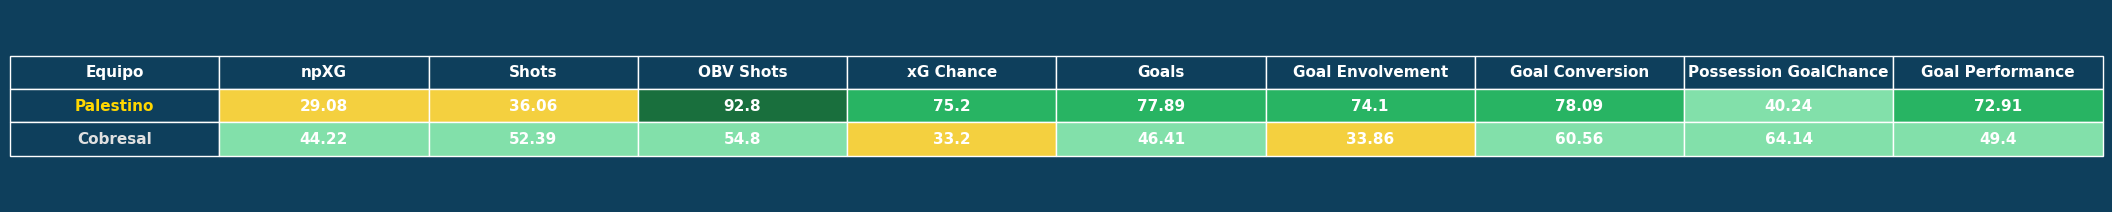

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Asegurarse de tener las columnas percentilizadas ---
pctl_metrics_dict = {
    'np_xg': 'npXG',
    'np_shots': 'Shots',
    'obv_shot': 'OBV Shots',
    'xgchain': 'xG Chance',
    'goals': 'Goals',
    'Goal Envolvement Index (norm)': 'Goal Envolvement',
    'Goal Conversion Index (norm)': 'Goal Conversion',
    'Possession GoalChance Index (norm)': 'Possession GoalChance',
    'Goal Performance Index': 'Goal Performance'
}

metrics = list(pctl_metrics_dict.keys())
pctl_metrics = [col + "_pctl" for col in metrics]
clean_labels = list(pctl_metrics_dict.values())

# Crear columnas percentilizadas
for col in metrics:
    df[col + "_pctl"] = df[col].rank(pct=True) * 100

# --- Elegir dos equipos ---
equipo1 = "Palestino"
equipo2 = "Cobresal"

# Obtener datos
row1 = df[df["team_name"] == equipo1].iloc[0]
row2 = df[df["team_name"] == equipo2].iloc[0]

# Obtener valores y redondear
equipo1_vals = [round(row1[m], 2) for m in pctl_metrics]
equipo2_vals = [round(row2[m], 2) for m in pctl_metrics]

# Crear la tabla sin índice
table_data = pd.DataFrame(
    [[equipo1] + equipo1_vals, [equipo2] + equipo2_vals],
    columns=["Equipo"] + clean_labels
)

# --- Función para colorear celdas por percentil ---
def color_cells(value):
    if value < 40:
        return '#f4d03f'  # amarillo
    elif 40 <= value < 65:
        return '#82e0aa'  # verde claro
    elif 65<= value < 85:
        return '#28b463'  # verde medio
    else:
        return '#196f3d'  # verde oscuro

# Color del texto por equipo
def text_color(equipo):
    return 'gold' if equipo == equipo1 else '#E0E0E0'

# Preparar colores (sin incluir la columna "Equipo")
cell_colors = [[color_cells(val) for val in row] for row in table_data.iloc[:, 1:].values]

# Agregar color de fondo a columna "Equipo"
full_colors = [['#0E3F5C'] + row for row in cell_colors]

# --- Dibujar tabla ---
fig, ax_table = plt.subplots(figsize=(15, 2.5), facecolor='#0E3F5C')
ax_table.axis("off")

table = ax_table.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellColours=full_colors,
    loc='center',
    cellLoc='center'
)

# Personalización visual
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.8, 2)

# Estética de las celdas
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('white')
    if i == 0:
        cell.set_text_props(color='white', weight='bold')  # encabezados
        cell.set_facecolor('#0E3F5C')
    else:
        if j == 0:
            equipo = table_data.iloc[i - 1, 0]
            cell.set_text_props(color=text_color(equipo), weight='bold')  # nombre del equipo
            cell.set_facecolor('#0E3F5C')
        else:
            cell.set_text_props(color='white', weight='bold')

# Guardar
output_path = "AUDAX/equipos_comparados.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
print(f"✅ Tabla guardada en {output_path}")

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import pi
import ipywidgets as widgets
from IPython.display import display
import os
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects

# --- Ruta base para escudos ---
ESCUDOS_PATH = "AUDAX/Chile Primeradivision/"

# --- Función para añadir imagen en coordenadas absolutas ---
def add_image(img_path, fig, left, bottom, width, height):
    try:
        new_ax = fig.add_axes([left, bottom, width, height], anchor='C', zorder=1)
        new_ax.imshow(mpimg.imread(img_path))
        new_ax.axis("off")
    except FileNotFoundError:
        print(f"⚠️ Imagen no encontrada: {img_path}")

# --- Cargar datos ---
df = pd.read_csv("AUDAX/df_final.csv")

# --- Métricas seleccionadas ---
metrics_dict = {
    'np_xg': 'npXG',
    'np_shots': 'Shots',
    'obv_shot': 'OBV Shots',
    'xgchain': 'xG Chance',
    'goals': 'Goals',
    'Goal Envolvement Index (norm)': 'Goal Envolvement',
    'Goal Conversion Index (norm)': 'Goal Conversion',
    'Possession GoalChance Index (norm)': 'Poss. GoalChance',
    'Goal Performance Index': 'Goal Performance'
}
metrics = list(metrics_dict.keys())
clean_labels = [metrics_dict[m] for m in metrics]

# --- Normalizar ---
for col in metrics:
    df[col + "_pctl"] = df[col].rank(pct=True) * 100
pctl_metrics = [m + "_pctl" for m in metrics]

# --- Widgets de equipo y jornada ---
available_teams = sorted([t for t in df["team_name"].unique() if t != "ALL_TEAMS_AVG"])
team_widget = widgets.Dropdown(options=available_teams, description="Equipo:", layout=widgets.Layout(width="50%"))

def get_jornada_options(equipo):
    sub = df[df["team_name"] == equipo][["match_week", "match_id"]].drop_duplicates()
    opts = []
    for _, r in sub.iterrows():
        mw, mid = r["match_week"], r["match_id"]
        mdf = df[df["match_id"] == mid]
        if mdf.shape[0] != 2: continue
        t1, t2 = mdf.iloc[0], mdf.iloc[1]
        local, visita = (t1, t2) if t1["team_name"] == t1["home_team"] else (t2, t1)
        marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
        label = f"J{mw} - {local['team_name']} {marcador} {visita['team_name']}"
        opts.append((label, mw))
    return opts

jornada_widget = widgets.Dropdown(options=get_jornada_options(team_widget.value), description="Jornada:", layout=widgets.Layout(width="70%"))
def update_jornadas(change):
    jornada_widget.options = get_jornada_options(change.new)

team_widget.observe(update_jornadas, names="value")

# --- Función principal ---
def plot_radar(equipo, jornada):
    md = df[(df["team_name"] == equipo) & (df["match_week"] == jornada)]
    if md.empty:
        print("❌ No se encontró ese equipo en esa jornada.")
        return
    mid = md.iloc[0]["match_id"]
    mdf = df[df["match_id"] == mid]
    if mdf.shape[0] != 2:
        print("❌ Datos incompletos.")
        return

    team_row = mdf[mdf["team_name"] == equipo].iloc[0]
    rival_row = mdf[mdf["team_name"] != equipo].iloc[0]

    team_vals = [team_row[m] for m in pctl_metrics]
    rival_vals = [rival_row[m] for m in pctl_metrics]
    team_vals += [team_vals[0]]
    rival_vals += [rival_vals[0]]

    N = len(metrics)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    local, visita = (team_row, rival_row) if team_row["team_name"] == team_row["home_team"] else (rival_row, team_row)
    marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
    title = f"{local['team_name']} {marcador} {visita['team_name']} - Jornada {jornada}"

    fig = plt.figure(figsize=(20, 17), facecolor="#0E3F5C", constrained_layout=False)
    gs = gridspec.GridSpec(3, 1, height_ratios=[3.5, 1.2, 0.3], figure=fig)

    radar_ax = fig.add_subplot(gs[0], polar=True, facecolor="#0E3F5C")
    radar_ax.plot(angles, team_vals, linewidth=3.5, linestyle='solid', label=equipo, color='gold')
    radar_ax.fill(angles, team_vals, color='gold', alpha=0.4)
    radar_ax.plot(angles, rival_vals, linewidth=3.5, linestyle='solid', label=rival_row["team_name"], color='lightgray')
    radar_ax.fill(angles, rival_vals, color='lightgray', alpha=0.4)

    radar_ax.set_xticks(angles[:-1])
    radar_ax.set_xticklabels(clean_labels, color='white', size=14)
    radar_ax.set_yticklabels([])
    radar_ax.yaxis.grid(True, linestyle='--', color='white', alpha=0.3)
    radar_ax.xaxis.grid(True, linestyle='--', color='white', alpha=0.3)
    radar_ax.spines['polar'].set_visible(False)
    radar_ax.set_title(title, color="white", fontsize=24, pad=40)
    radar_ax.legend(loc='lower right', fontsize=14, labelcolor='white', frameon=False, bbox_to_anchor=(0.05, -0.1))


    fig.text(0.5, 0.95, f"GoalPerformance Team Comparison", ha='center', va='center', color='lightgray', fontsize=26, fontweight='bold')

    add_image(os.path.join(ESCUDOS_PATH, f"{local['team_name']}.png"), fig, left=0.02, bottom=0.80, width=0.15, height=0.15)
    add_image(os.path.join(ESCUDOS_PATH, f"{visita['team_name']}.png"), fig, left=0.86, bottom=0.80, width=0.15, height=0.15)

    tabla_ax = fig.add_subplot(gs[1])
    tabla_ax.axis("off")
    df_tabla = pd.DataFrame(
        [[equipo] + [round(team_row[m], 2) for m in pctl_metrics],
         [rival_row["team_name"]] + [round(rival_row[m], 2) for m in pctl_metrics]],
        columns=["Equipo"] + clean_labels
    )

    def color_cells(value):
        if value < 40: return '#f4d03f'
        elif 40 <= value < 65: return '#82e0aa'
        elif 65 <= value < 85: return '#28b463'
        else: return '#196f3d'

    def text_color(name): return 'gold' if name == equipo else '#E0E0E0'
    colores = [[color_cells(val) for val in row] for row in df_tabla.iloc[:, 1:].values]
    colores_final = [['#0E3F5C'] + row for row in colores]

    tabla = tabla_ax.table(
        cellText=df_tabla.values,
        colLabels=df_tabla.columns,
        cellColours=colores_final,
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.3, 2)

    for (i, j), cell in tabla.get_celld().items():
        cell.set_edgecolor('white')
        if i == 0:
            cell.set_text_props(color='white', weight='bold')
            cell.set_facecolor('#0E3F5C')
        else:
            if j == 0:
                cell.set_text_props(color=text_color(df_tabla.iloc[i-1, 0]), weight='bold')
                cell.set_facecolor('#0E3F5C')
            else:
                cell.set_text_props(color='white', weight='bold')

    fig.text(0.97, 0.2, "Data StatsBomb Teams GoalPerformance | code by: @Sevi", color='lightgray', fontsize=10, ha='right', va='bottom')

    # Guardar
    output_path = "AUDAX/Radar_Comaprativo.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    print(f"✅ Imagen Radar guardada en {output_path}")

    plt.show()

# --- Interfaz interactiva ---
ui = widgets.VBox([team_widget, jornada_widget])
out = widgets.interactive_output(plot_radar, {"equipo": team_widget, "jornada": jornada_widget})
display(ui, out)


Output()

In [ ]:
# --- IMPORTS ---
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import pi
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

# --- RUTAS ---
ESCUDOS_PATH = "AUDAX/Chile Primeradivision/"
DATA_PATH = "AUDAX/df_final.csv"

# --- CARGA DE DATOS ---
df = pd.read_csv(DATA_PATH)
match_df = df[df["match_id"] != "AVG"].copy()
match_df["match_id"] = match_df["match_id"].astype(str)
match_df["x_label"] = match_df.apply(lambda row: f"J{row['match_week']}: {row['match_score']}", axis=1)

# --- MÉTRICAS ---
metrics_dict = {
    'np_xg': 'npXG',
    'np_shots': 'Shots',
    'obv_shot': 'OBV Shots',
    'xgchain': 'xG Chance',
    'goals': 'Goals',
    'Goal Envolvement Index (norm)': 'Goal Envolvement',
    'Goal Conversion Index (norm)': 'Goal Conversion',
    'Possession GoalChance Index (norm)': 'Poss. GoalChance',
    'Goal Performance Index': 'Goal Performance'
}
metrics = list(metrics_dict.keys())
clean_labels = [metrics_dict[m] for m in metrics]

# Añadir columnas percentil
for col in metrics:
    df[col + "_pctl"] = df[col].rank(pct=True) * 100
pctl_metrics = [m + "_pctl" for m in metrics]

# --- KPIs Evolutivos ---
kpi_list = [
    "Goal Envolvement Index (norm)",
    "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)",
    "Goal Performance Index"
]

# --- FUNCIONES ---
def get_jornada_options(equipo):
    sub = df[df["team_name"] == equipo][["match_week", "match_id"]].drop_duplicates()
    opts = []
    for _, r in sub.iterrows():
        mw, mid = r["match_week"], r["match_id"]
        mdf = df[df["match_id"] == mid]
        if mdf.shape[0] != 2: continue
        t1, t2 = mdf.iloc[0], mdf.iloc[1]
        local, visita = (t1, t2) if t1["team_name"] == t1["home_team"] else (t2, t1)
        marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
        label = f"J{mw} - {local['team_name']} {marcador} {visita['team_name']}"
        opts.append((label, mw))
    return opts

def add_image(img_path, fig, left, bottom, width, height):
    try:
        new_ax = fig.add_axes([left, bottom, width, height], anchor='C', zorder=1)
        new_ax.imshow(mpimg.imread(img_path))
        new_ax.axis("off")
    except FileNotFoundError:
        print(f"⚠️ Imagen no encontrada: {img_path}")

# --- FUNCIONES ---

def plot_radar_and_kpis(equipo, jornada):
    output.clear_output(wait=True)
    with output:
        md = df[(df["team_name"] == equipo) & (df["match_week"] == jornada)]
        if md.empty:
            print("❌ No se encontró ese equipo en esa jornada.")
            return
        mid = md.iloc[0]["match_id"]
        mdf = df[df["match_id"] == mid]
        if mdf.shape[0] != 2:
            print("❌ Datos incompletos.")
            return

        team_row = mdf[mdf["team_name"] == equipo].iloc[0]
        rival_row = mdf[mdf["team_name"] != equipo].iloc[0]

        team_vals = [team_row[m] for m in pctl_metrics] + [team_row[pctl_metrics[0]]]
        rival_vals = [rival_row[m] for m in pctl_metrics] + [rival_row[pctl_metrics[0]]]
        angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))] + [0]

        local, visita = (team_row, rival_row) if team_row["team_name"] == team_row["home_team"] else (rival_row, team_row)
        marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
        title = f"{local['team_name']} {marcador} {visita['team_name']} - Jornada {jornada}"

        fig = plt.figure(figsize=(20, 30), facecolor="#0E3F5C")
        gs = gridspec.GridSpec(3, 1, height_ratios=[1.6, 0.6, 1.4], figure=fig)

        # Subtítulo
        fig.text(0.5, 0.91, "GoalPerformance Team Comparison", ha='center', va='center', color='lightgray', fontsize=26, fontweight='bold')

        # --- RADAR ---
        radar_ax = fig.add_subplot(gs[0], polar=True, facecolor="#0E3F5C")

        # Cambiar borde diametral externo a gris claro
        radar_ax.spines['polar'].set_color((0.8, 0.8, 0.8, 0.2))  # Gris claro con baja opacidad
        radar_ax.spines['polar'].set_linewidth(1.5)

        radar_ax.plot(angles, team_vals, linewidth=3, label=equipo, color='gold')
        radar_ax.fill(angles, team_vals, color='gold', alpha=0.4)
        radar_ax.plot(angles, rival_vals, linewidth=3, label=rival_row["team_name"], color='lightgray')
        radar_ax.fill(angles, rival_vals, color='lightgray', alpha=0.4)
        radar_ax.set_xticks(angles[:-1])
        radar_ax.set_xticklabels(clean_labels, color='white', size=15)
        radar_ax.set_yticklabels([])
        radar_ax.grid(True, color="white", linestyle='--', alpha=0.3)
        radar_ax.set_title(title, color="white", fontsize=20, pad=30)

        # Leyendas en blanco
        legend = radar_ax.legend(loc='lower left', fontsize=20, frameon=False, bbox_to_anchor=(-0.3, -0.1))
        for text in legend.get_texts():
            text.set_color('white')
        
        fig.text(0.97, 0.5, "Data StatsBomb Teams GoalPerformance | code by: @Sevi", color='lightgray', fontsize=12, ha='right', va='bottom')
        
        add_image(os.path.join(ESCUDOS_PATH, f"{local['team_name']}.png"), fig, 0.05, 0.82, 0.12, 0.12)
        add_image(os.path.join(ESCUDOS_PATH, f"{visita['team_name']}.png"), fig, 0.83, 0.82, 0.12, 0.12)

        # --- TABLA ---
        tabla_ax = fig.add_subplot(gs[1])
        tabla_ax.axis("off")
        df_tabla = pd.DataFrame(
            [[equipo] + [round(team_row[m], 2) for m in pctl_metrics],
             [rival_row["team_name"]] + [round(rival_row[m], 2) for m in pctl_metrics]],
            columns=["Equipo"] + clean_labels
        )

        def color_cells(value):
            if value < 40: return '#f4d03f'
            elif 40 <= value < 65: return '#82e0aa'
            elif 65 <= value < 85: return '#28b463'
            else: return '#196f3d'

        def text_color(name): return 'gold' if name == equipo else '#E0E0E0'
        colores = [[color_cells(val) for val in row] for row in df_tabla.iloc[:, 1:].values]
        colores_final = [['#0E3F5C'] + row for row in colores]

        tabla = tabla_ax.table(
            cellText=df_tabla.values,
            colLabels=df_tabla.columns,
            cellColours=colores_final,
            cellLoc='center',
            loc='center'
        )
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(11)
        tabla.scale(1.3, 2)

        for (i, j), cell in tabla.get_celld().items():
            cell.set_edgecolor('white')
            if i == 0:
                cell.set_text_props(color='white', weight='bold')
                cell.set_facecolor('#0E3F5C')
            else:
                if j == 0:
                    cell.set_text_props(color=text_color(df_tabla.iloc[i-1, 0]), weight='bold')
                    cell.set_facecolor('#0E3F5C')
                else:
                    cell.set_text_props(color='white', weight='bold')

        # --- KPIs EVOLUTIVOS ---
        team_df = match_df[match_df["team_name"] == equipo].sort_values("match_week")
        kpi_ax = fig.add_subplot(gs[2])
        kpi_ax.axis("off")

        legend_lines = []

        # Subtítulo de los KPIs evolutivos
        fig.text(0.5, 0.43, "Evolución de KPIs", ha='center', va='center', color='lightgray', fontsize=26, fontweight='bold')

        for i, kpi in enumerate(kpi_list):
            sub_ax = fig.add_axes([0.07 + (i % 2) * 0.46, 0.04 + (1 - i // 2) * 0.2, 0.4, 0.15], facecolor="#0E3F5C")
            team_avg = team_df[kpi].mean()
            all_avg = match_df[kpi].mean()

            line_team, = sub_ax.plot(team_df["x_label"], team_df[kpi], marker='o', color='lime', label=equipo)
            line_team_avg = sub_ax.axhline(team_avg, color='green', linestyle='--', label=f'Prom. {equipo}')
            line_all_avg = sub_ax.axhline(all_avg, color='orange', linestyle=':', label='Prom. Todos')

            # Solo una vez guardamos las líneas para la leyenda general
            if i == 0:
                 legend_lines = [
                     Line2D([0], [0], color='lime', marker='o', label=equipo),
                     Line2D([0], [0], color='green', linestyle='--', label=f'Prom. {equipo}'),
                     Line2D([0], [0], color='orange', linestyle=':', label='Prom. Todos')
                ]

            sub_ax.set_title(kpi.replace(" (norm)", ""), color="white", fontsize=13)
            sub_ax.tick_params(colors='white', labelsize=8)

            # Mostrar solo etiquetas "J1", "J2", ...
            jornadas_labels = team_df["match_week"].apply(lambda x: f"J{x}").tolist()
            sub_ax.set_xticks(team_df["x_label"])
            sub_ax.set_xticklabels(jornadas_labels, rotation=30, ha='right')
            sub_ax.grid(color='white', linestyle='--', alpha=0.2)

        # Cambiar el color de texto a gris claro
        for text in legend.get_texts():
            text.set_color('lightgray')

        # 🔥 Añadir leyenda única fuera del área de los subplots
        fig.legend(handles=legend_lines, loc='upper center', bbox_to_anchor=(0.5, 0.42), ncol=3, fontsize=18, frameon=False)

        # Guardar
        output_path = "AUDAX/Radar_Comaprativo.png"
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"✅ Imagen Radar guardada en {output_path}")

        plt.show()



# --- WIDGETS ---
available_teams = sorted([t for t in df["team_name"].unique() if t != "ALL_TEAMS_AVG"])
team_widget = widgets.Dropdown(options=available_teams, description="Equipo:", layout=widgets.Layout(width="40%"))
jornada_widget = widgets.Dropdown(options=get_jornada_options(team_widget.value), description="Jornada:", layout=widgets.Layout(width="60%"))

def update_jornadas(change):
    jornada_widget.options = get_jornada_options(change.new)
    plot_radar_and_kpis(change.new, jornada_widget.value)

def on_jornada_change(change):
    plot_radar_and_kpis(team_widget.value, change.new)

team_widget.observe(update_jornadas, names="value")
jornada_widget.observe(on_jornada_change, names="value")

output = widgets.Output()
ui_controls = widgets.HBox([team_widget, jornada_widget])
display(widgets.VBox([ui_controls, output]))

# Inicial
plot_radar_and_kpis(team_widget.value, jornada_widget.value)


In [ ]:
# --- IMPORTS ---
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import pi
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

# --- RUTAS ---
ESCUDOS_PATH = "AUDAX/Chile Primeradivision/"
DATA_PATH = "AUDAX/df_final.csv"

# --- CARGA DE DATOS ---
df = pd.read_csv(DATA_PATH)
match_df = df[df["match_id"] != "AVG"].copy()
match_df["match_id"] = match_df["match_id"].astype(str)
match_df["x_label"] = match_df.apply(lambda row: f"J{row['match_week']}: {row['match_score']}", axis=1)

# --- MÉTRICAS ---
metrics_dict = {
    'np_xg': 'npXG',
    'np_shots': 'Shots',
    'obv_shot': 'OBV Shots',
    'xgchain': 'xG Chance',
    'goals': 'Goals',
    'Goal Envolvement Index (norm)': 'Goal Envolvement',
    'Goal Conversion Index (norm)': 'Goal Conversion',
    'Possession GoalChance Index (norm)': 'Poss. GoalChance',
    'Goal Performance Index': 'Goal Performance'
}
metrics = list(metrics_dict.keys())
clean_labels = [metrics_dict[m] for m in metrics]

# Añadir columnas percentil
for col in metrics:
    df[col + "_pctl"] = df[col].rank(pct=True) * 100
pctl_metrics = [m + "_pctl" for m in metrics]

# --- KPIs Evolutivos ---
kpi_list = [
    "Goal Envolvement Index (norm)",
    "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)",
    "Goal Performance Index"
]

# --- FUNCIONES ---
def get_jornada_options(equipo):
    sub = df[df["team_name"] == equipo][["match_week", "match_id"]].drop_duplicates()
    opts = []
    for _, r in sub.iterrows():
        mw, mid = r["match_week"], r["match_id"]
        mdf = df[df["match_id"] == mid]
        if mdf.shape[0] != 2: continue
        t1, t2 = mdf.iloc[0], mdf.iloc[1]
        local, visita = (t1, t2) if t1["team_name"] == t1["home_team"] else (t2, t1)
        marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
        label = f"J{mw} - {local['team_name']} {marcador} {visita['team_name']}"
        opts.append((label, mw))
    return opts

def add_image(img_path, fig, left, bottom, width, height):
    try:
        new_ax = fig.add_axes([left, bottom, width, height], anchor='C', zorder=1)
        new_ax.imshow(mpimg.imread(img_path))
        new_ax.axis("off")
    except FileNotFoundError:
        print(f"⚠️ Imagen no encontrada: {img_path}")

# --- FUNCIONES ---

def plot_radar_and_kpis(equipo, jornada):
    output.clear_output(wait=True)
    with output:
        md = df[(df["team_name"] == equipo) & (df["match_week"] == jornada)]
        if md.empty:
            print("❌ No se encontró ese equipo en esa jornada.")
            return
        mid = md.iloc[0]["match_id"]
        mdf = df[df["match_id"] == mid]
        if mdf.shape[0] != 2:
            print("❌ Datos incompletos.")
            return

        team_row = mdf[mdf["team_name"] == equipo].iloc[0]
        rival_row = mdf[mdf["team_name"] != equipo].iloc[0]

        team_vals = [team_row[m] for m in pctl_metrics] + [team_row[pctl_metrics[0]]]
        rival_vals = [rival_row[m] for m in pctl_metrics] + [rival_row[pctl_metrics[0]]]
        angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))] + [0]

        local, visita = (team_row, rival_row) if team_row["team_name"] == team_row["home_team"] else (rival_row, team_row)
        marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
        title = f"{local['team_name']} {marcador} {visita['team_name']} - Jornada {jornada}"

        fig = plt.figure(figsize=(20, 30), facecolor="#0E3F5C")
        gs = gridspec.GridSpec(3, 1, height_ratios=[1.6, 0.6, 1.4], figure=fig)

        # Subtítulo
        fig.text(0.5, 0.91, "GoalPerformance Team Comparison", ha='center', va='center', color='lightgray', fontsize=26, fontweight='bold')

        # --- RADAR ---
        radar_ax = fig.add_subplot(gs[0], polar=True, facecolor="#0E3F5C")

        radar_ax.spines['polar'].set_color((0.8, 0.8, 0.8, 0.2))
        radar_ax.spines['polar'].set_linewidth(1.5)

        radar_ax.plot(angles, team_vals, linewidth=3, label=equipo, color='gold')
        radar_ax.fill(angles, team_vals, color='gold', alpha=0.4)
        radar_ax.plot(angles, rival_vals, linewidth=3, label=rival_row["team_name"], color='lightgray')
        radar_ax.fill(angles, rival_vals, color='lightgray', alpha=0.4)
        radar_ax.set_xticks(angles[:-1])
        radar_ax.set_xticklabels(clean_labels, color='white', size=15)
        radar_ax.set_yticklabels([])
        radar_ax.grid(True, color="white", linestyle='--', alpha=0.3)
        radar_ax.set_title(title, color="white", fontsize=20, pad=30)

        legend = radar_ax.legend(loc='lower left', fontsize=20, frameon=False, bbox_to_anchor=(-0.3, -0.1))
        for text in legend.get_texts():
            text.set_color('white')
        
        fig.text(0.97, 0.5, "Data StatsBomb Teams GoalPerformance | code by: @Sevi", color='lightgray', fontsize=12, ha='right', va='bottom')
        
        add_image(os.path.join(ESCUDOS_PATH, f"{local['team_name']}.png"), fig, 0.05, 0.82, 0.12, 0.12)
        add_image(os.path.join(ESCUDOS_PATH, f"{visita['team_name']}.png"), fig, 0.83, 0.82, 0.12, 0.12)

        # --- TABLA ---
        tabla_ax = fig.add_subplot(gs[1])
        tabla_ax.axis("off")
        df_tabla = pd.DataFrame(
            [[equipo] + [round(team_row[m], 2) for m in pctl_metrics],
             [rival_row["team_name"]] + [round(rival_row[m], 2) for m in pctl_metrics]],
            columns=["Equipo"] + clean_labels
        )

        def color_cells(value):
            if value < 40: return '#f4d03f'
            elif 40 <= value < 65: return '#82e0aa'
            elif 65 <= value < 85: return '#28b463'
            else: return '#196f3d'

        def text_color(name): return 'gold' if name == equipo else '#E0E0E0'
        colores = [[color_cells(val) for val in row] for row in df_tabla.iloc[:, 1:].values]
        colores_final = [['#0E3F5C'] + row for row in colores]

        tabla = tabla_ax.table(
            cellText=df_tabla.values,
            colLabels=df_tabla.columns,
            cellColours=colores_final,
            cellLoc='center',
            loc='center'
        )
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(11)
        tabla.scale(1.3, 2)

        for (i, j), cell in tabla.get_celld().items():
            cell.set_edgecolor('white')
            if i == 0:
                cell.set_text_props(color='white', weight='bold')
                cell.set_facecolor('#0E3F5C')
            else:
                if j == 0:
                    cell.set_text_props(color=text_color(df_tabla.iloc[i-1, 0]), weight='bold')
                    cell.set_facecolor('#0E3F5C')
                else:
                    cell.set_text_props(color='white', weight='bold')

        # --- KPIs EVOLUTIVOS ---
        team_df = match_df[match_df["team_name"] == equipo].sort_values("match_week")
        kpi_ax = fig.add_subplot(gs[2])
        kpi_ax.axis("off")

        legend_lines = []

        fig.text(0.5, 0.43, "Evolución de KPIs", ha='center', va='center', color='lightgray', fontsize=26, fontweight='bold')

        for i, kpi in enumerate(kpi_list):
            sub_ax = fig.add_axes([0.07 + (i % 2) * 0.46, 0.04 + (1 - i // 2) * 0.2, 0.4, 0.15], facecolor="#0E3F5C")
            team_avg = team_df[kpi].mean()
            all_avg = match_df[kpi].mean()

            # Graficar todos los puntos normales
            sub_ax.plot(team_df["x_label"], team_df[kpi], marker='o', color='lime', label=equipo, markersize=6)

            # Resaltar nodo de la jornada seleccionada
            if jornada in team_df["match_week"].values:
                idx = team_df[team_df["match_week"] == jornada].index[0]
                x = team_df.loc[idx, "x_label"]
                y = team_df.loc[idx, kpi]
                sub_ax.plot(x, y, marker='o', markersize=13, markeredgewidth=2, markeredgecolor='black', markerfacecolor='greenyellow', zorder=5)

            # Líneas promedio
            sub_ax.axhline(team_avg, color='palegreen', linestyle='--', label=f'Prom. {equipo}')
            sub_ax.axhline(all_avg, color='lightgray', linestyle=':', label='Prom.Liga')

            if i == 0:
                 legend_lines = [
                     Line2D([0], [0], color='lime', marker='o', label=equipo),
                     Line2D([0], [0], color='palegreen', linestyle='--', label=f'Prom. {equipo}'),
                     Line2D([0], [0], color='lightgray', linestyle=':', label='Prom. Liga')
                ]

            sub_ax.set_title(kpi.replace(" (norm)", ""), color="white", fontsize=1)
            sub_ax.tick_params(colors='white', labelsize=10)

            jornadas_labels = team_df["match_week"].apply(lambda x: f"J{x}").tolist()
            sub_ax.set_xticks(team_df["x_label"])
            sub_ax.set_xticklabels(jornadas_labels, rotation=30, ha='right')
            sub_ax.grid(color='white', linestyle='--', alpha=0.2)

        for text in legend.get_texts():
            text.set_color('lightgray')

        fig.legend(handles=legend_lines, loc='upper center', bbox_to_anchor=(0.5, 0.42), ncol=3, fontsize=18, frameon=False)

        output_path = "AUDAX/Radar_Comaprativo.png"
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"✅ Imagen Radar guardada en {output_path}")

        plt.show()


# --- WIDGETS ---
available_teams = sorted([t for t in df["team_name"].unique() if t != "ALL_TEAMS_AVG"])
team_widget = widgets.Dropdown(options=available_teams, description="Equipo:", layout=widgets.Layout(width="40%"))
jornada_widget = widgets.Dropdown(options=get_jornada_options(team_widget.value), description="Jornada:", layout=widgets.Layout(width="60%"))

def update_jornadas(change):
    jornada_widget.options = get_jornada_options(change.new)
    plot_radar_and_kpis(change.new, jornada_widget.value)

def on_jornada_change(change):
    plot_radar_and_kpis(team_widget.value, change.new)

team_widget.observe(update_jornadas, names="value")
jornada_widget.observe(on_jornada_change, names="value")

output = widgets.Output()
ui_controls = widgets.HBox([team_widget, jornada_widget])
display(widgets.VBox([ui_controls, output]))

# Inicial
plot_radar_and_kpis(team_widget.value, jornada_widget.value)


In [ ]:
# --- IMPORTS ---
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from math import pi
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

# --- RUTAS ---
ESCUDOS_PATH = "AUDAX/Chile Primeradivision/"
DATA_PATH = "AUDAX/df_final.csv"

# --- CARGA DE DATOS ---
df = pd.read_csv(DATA_PATH)
match_df = df[df["match_id"] != "AVG"].copy()
match_df["match_id"] = match_df["match_id"].astype(str)
match_df["x_label"] = match_df.apply(lambda row: f"J{row['match_week']}: {row['match_score']}", axis=1)

# --- MÉTRICAS ---
metrics_dict = {
    'np_xg': 'npXG',
    'np_shots': 'Shots',
    'obv_shot': 'OBV Shots',
    'xgchain': 'xG Chance',
    'goals': 'Goals',
    'Goal Envolvement Index (norm)': 'Goal Envolvement',
    'Goal Conversion Index (norm)': 'Goal Conversion',
    'Possession GoalChance Index (norm)': 'Poss. GoalChance',
    'Goal Performance Index': 'Goal Performance'
}
metrics = list(metrics_dict.keys())
clean_labels = [metrics_dict[m] for m in metrics]

# Añadir columnas percentil
for col in metrics:
    df[col + "_pctl"] = df[col].rank(pct=True) * 100
pctl_metrics = [m + "_pctl" for m in metrics]

# --- KPIs Evolutivos ---
kpi_list = [
    "Goal Envolvement Index (norm)",
    "Goal Conversion Index (norm)",
    "Possession GoalChance Index (norm)",
    "Goal Performance Index"
]

# --- FUNCIONES ---
def get_jornada_options(equipo):
    sub = df[df["team_name"] == equipo][["match_week", "match_id"]].drop_duplicates()
    opts = []
    for _, r in sub.iterrows():
        mw, mid = r["match_week"], r["match_id"]
        mdf = df[df["match_id"] == mid]
        if mdf.shape[0] != 2: continue
        t1, t2 = mdf.iloc[0], mdf.iloc[1]
        local, visita = (t1, t2) if t1["team_name"] == t1["home_team"] else (t2, t1)
        marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
        label = f"J{mw} - {local['team_name']} {marcador} {visita['team_name']}"
        opts.append((label, mw))
    return opts

def add_image(img_path, fig, left, bottom, width, height):
    try:
        new_ax = fig.add_axes([left, bottom, width, height], anchor='C', zorder=1)
        new_ax.imshow(mpimg.imread(img_path))
        new_ax.axis("off")
    except FileNotFoundError:
        print(f"⚠️ Imagen no encontrada: {img_path}")

# --- FUNCIONES ---

def plot_radar_and_kpis(equipo, jornada):
    output.clear_output(wait=True)
    with output:
        md = df[(df["team_name"] == equipo) & (df["match_week"] == jornada)]
        if md.empty:
            print("❌ No se encontró ese equipo en esa jornada.")
            return
        mid = md.iloc[0]["match_id"]
        mdf = df[df["match_id"] == mid]
        if mdf.shape[0] != 2:
            print("❌ Datos incompletos.")
            return

        team_row = mdf[mdf["team_name"] == equipo].iloc[0]
        rival_row = mdf[mdf["team_name"] != equipo].iloc[0]

        team_vals = [team_row[m] for m in pctl_metrics] + [team_row[pctl_metrics[0]]]
        rival_vals = [rival_row[m] for m in pctl_metrics] + [rival_row[pctl_metrics[0]]]
        angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))] + [0]

        local, visita = (team_row, rival_row) if team_row["team_name"] == team_row["home_team"] else (rival_row, team_row)
        marcador = f"{int(local['goals'])}-{int(visita['goals'])}"
        title = f"{local['team_name']} {marcador} {visita['team_name']} - Jornada {jornada}"

        fig = plt.figure(figsize=(20, 30), facecolor="#0E3F5C")
        gs = gridspec.GridSpec(3, 1, height_ratios=[1.6, 0.6, 1.4], figure=fig)

        # Subtítulo
        fig.text(0.5, 0.91, "GoalPerformance Team Comparison", ha='center', va='center', color='lightgray', fontsize=26, fontweight='bold')

        # --- RADAR ---
        radar_ax = fig.add_subplot(gs[0], polar=True, facecolor="#0E3F5C")

        radar_ax.spines['polar'].set_color((0.8, 0.8, 0.8, 0.2))
        radar_ax.spines['polar'].set_linewidth(1.5)

        radar_ax.plot(angles, team_vals, linewidth=3, label=equipo, color='gold')
        radar_ax.fill(angles, team_vals, color='gold', alpha=0.4)
        radar_ax.plot(angles, rival_vals, linewidth=3, label=rival_row["team_name"], color='lightgray')
        radar_ax.fill(angles, rival_vals, color='lightgray', alpha=0.4)
        radar_ax.set_xticks(angles[:-1])
        radar_ax.set_xticklabels(clean_labels, color='white', size=15)
        radar_ax.set_yticklabels([])
        radar_ax.grid(True, color="white", linestyle='--', alpha=0.3)
        radar_ax.set_title(title, color="white", fontsize=20, pad=30)

        legend = radar_ax.legend(loc='lower left', fontsize=20, frameon=False, bbox_to_anchor=(-0.3, -0.1))
        for text in legend.get_texts():
            text.set_color('white')
        
        fig.text(0.97, 0.5, "Data StatsBomb Teams GoalPerformance | code by: @Sevi", color='lightgray', fontsize=12, ha='right', va='bottom')
        
        add_image(os.path.join(ESCUDOS_PATH, f"{local['team_name']}.png"), fig, 0.05, 0.82, 0.12, 0.12)
        add_image(os.path.join(ESCUDOS_PATH, f"{visita['team_name']}.png"), fig, 0.83, 0.82, 0.12, 0.12)

        # --- TABLA ---
        tabla_ax = fig.add_subplot(gs[1])
        tabla_ax.axis("off")
        df_tabla = pd.DataFrame(
            [[equipo] + [round(team_row[m], 2) for m in pctl_metrics],
             [rival_row["team_name"]] + [round(rival_row[m], 2) for m in pctl_metrics]],
            columns=["Equipo"] + clean_labels
        )

        def color_cells(value):
            if value < 40: return '#f4d03f'
            elif 40 <= value < 65: return '#82e0aa'
            elif 65 <= value < 85: return '#28b463'
            else: return '#196f3d'

        def text_color(name): return 'gold' if name == equipo else '#E0E0E0'
        colores = [[color_cells(val) for val in row] for row in df_tabla.iloc[:, 1:].values]
        colores_final = [['#0E3F5C'] + row for row in colores]

        tabla = tabla_ax.table(
            cellText=df_tabla.values,
            colLabels=df_tabla.columns,
            cellColours=colores_final,
            cellLoc='center',
            loc='center'
        )
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(11)
        tabla.scale(1.3, 2)

        for (i, j), cell in tabla.get_celld().items():
            cell.set_edgecolor('white')
            if i == 0:
                cell.set_text_props(color='white', weight='bold')
                cell.set_facecolor('#0E3F5C')
            else:
                if j == 0:
                    cell.set_text_props(color=text_color(df_tabla.iloc[i-1, 0]), weight='bold')
                    cell.set_facecolor('#0E3F5C')
                else:
                    cell.set_text_props(color='white', weight='bold')

        # --- KPIs EVOLUTIVOS ---
        team_df = match_df[match_df["team_name"] == equipo].sort_values("match_week")
        kpi_ax = fig.add_subplot(gs[2])
        kpi_ax.axis("off")

        legend_lines = []

        fig.text(0.5, 0.43, "Evolución de KPIs", ha='center', va='center', color='lightgray', fontsize=26, fontweight='bold')

        for i, kpi in enumerate(kpi_list):
            sub_ax = fig.add_axes([0.07 + (i % 2) * 0.46, 0.04 + (1 - i // 2) * 0.2, 0.4, 0.15], facecolor="#0E3F5C")
            team_avg = team_df[kpi].mean()
            all_avg = match_df[kpi].mean()

            # Graficar todos los puntos normales
            sub_ax.plot(team_df["x_label"], team_df[kpi], marker='o', color='lime', label=equipo, markersize=6)

            # Resaltar nodo de la jornada seleccionada
            if jornada in team_df["match_week"].values:
                idx = team_df[team_df["match_week"] == jornada].index[0]
                x = team_df.loc[idx, "x_label"]
                y = team_df.loc[idx, kpi]
                sub_ax.plot(x, y, marker='o', markersize=13, markeredgewidth=2, markeredgecolor='black', markerfacecolor='greenyellow', zorder=5)

            # Líneas promedio
            sub_ax.axhline(team_avg, color='palegreen', linestyle='--', label=f'Prom. {equipo}')
            sub_ax.axhline(all_avg, color='lightgray', linestyle=':', label='Prom. Liga')

            if i == 0:
                 legend_lines = [
                     Line2D([0], [0], color='lime', marker='o', label=equipo),
                     Line2D([0], [0], color='palegreen', linestyle='--', label=f'Prom. {equipo}'),
                     Line2D([0], [0], color='lightgray', linestyle=':', label='Prom. Liga')
                ]

            sub_ax.set_title(kpi.replace(" (norm)", ""), color="white", fontsize=1)
            sub_ax.tick_params(colors='white', labelsize=10)

            jornadas_labels = team_df["match_week"].apply(lambda x: f"J{x}").tolist()
            sub_ax.set_xticks(team_df["x_label"])
            sub_ax.set_xticklabels(jornadas_labels, rotation=30, ha='right')
            sub_ax.grid(color='white', linestyle='--', alpha=0.2)

        for text in legend.get_texts():
            text.set_color('lightgray')

        fig.legend(handles=legend_lines, loc='upper center', bbox_to_anchor=(0.5, 0.42), ncol=3, fontsize=18, frameon=False)

        output_path = "AUDAX/Radar_Comaprativo.png"
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
        print(f"✅ Imagen Radar guardada en {output_path}")

        plt.show()


# --- WIDGETS ---
available_teams = sorted([t for t in df["team_name"].unique() if t != "ALL_TEAMS_AVG"])
team_widget = widgets.Dropdown(options=available_teams, description="Equipo:", layout=widgets.Layout(width="40%"))
jornada_widget = widgets.Dropdown(options=get_jornada_options(team_widget.value), description="Jornada:", layout=widgets.Layout(width="60%"))

def update_jornadas(change):
    jornada_widget.options = get_jornada_options(change.new)
    plot_radar_and_kpis(change.new, jornada_widget.value)

def on_jornada_change(change):
    plot_radar_and_kpis(team_widget.value, change.new)

team_widget.observe(update_jornadas, names="value")
jornada_widget.observe(on_jornada_change, names="value")

output = widgets.Output()
ui_controls = widgets.HBox([team_widget, jornada_widget])
display(widgets.VBox([ui_controls, output]))

# Inicial
plot_radar_and_kpis(team_widget.value, jornada_widget.value)
